In [1]:
from pathlib import Path
from importlib import reload
import matplotlib.pyplot as plt
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.auto import trange, tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sys
sys.path.insert(0, '/app')
from torch.utils.tensorboard import SummaryWriter
from lib.utils import plot_hist, score_func

In [2]:
from models.model import Model
import models.gans as gan
import models.vae as vae

In [3]:
seed = 52
logdir = Path('/_data/richgan/runs')
tag = 'vanila'
# Вспомогательная функция, чтобы генерить одинаковые модели для каждой частицы
def get_model():
    latent_dim = 32
    condition_dim = 3
    target_dim = 5
    d_hidden_dims = [64, 64, 128, 128]
    g_hidden_dims = [64, 64, 128, 128]
    

    device = torch.device('cuda:1')
    generator = gan.MLPGenerator(latent_dim, condition_dim, g_hidden_dims, target_dim,).to(device)
    discriminator = gan.MLPDiscriminator(target_dim, condition_dim, d_hidden_dims).to(device)

    generator_opt = optim.Adam(generator.parameters(),  lr=1e-4, betas=(0, 0.9))
    discriminator_opt = optim.Adam(discriminator.parameters(),  lr=1e-4, betas=(0, 0.9))

    model = gan.CGAN(
        generator,
        discriminator,
        generator_opt,
        discriminator_opt,
        relativistic=None,
        smooth_labels=(0.1, 0.1),
        flip_labels=None,
    )
    
    return Model(
        model,
        QuantileTransformer(output_distribution='normal', random_state=seed),
        QuantileTransformer(output_distribution='normal', random_state=seed),
        simulate_error_codes=True,
    )


In [4]:
data_dir = Path('/_data/data_csv/')

dataframes = {}
for file in tqdm(data_dir.iterdir()):
    name = file.stem.split('_')[1]
    train, test = train_test_split(pd.read_csv(file.as_posix(), dtype=np.float32), random_state=seed)
    dataframes[name]  =  {'train': train, 'test': test}
    
condition_cols = ['TrackP', 'TrackEta', 'NumLongTracks']
target_cols = ['RichDLLbt', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLe']


proton :  0.00993603974415902
RichDLLbt


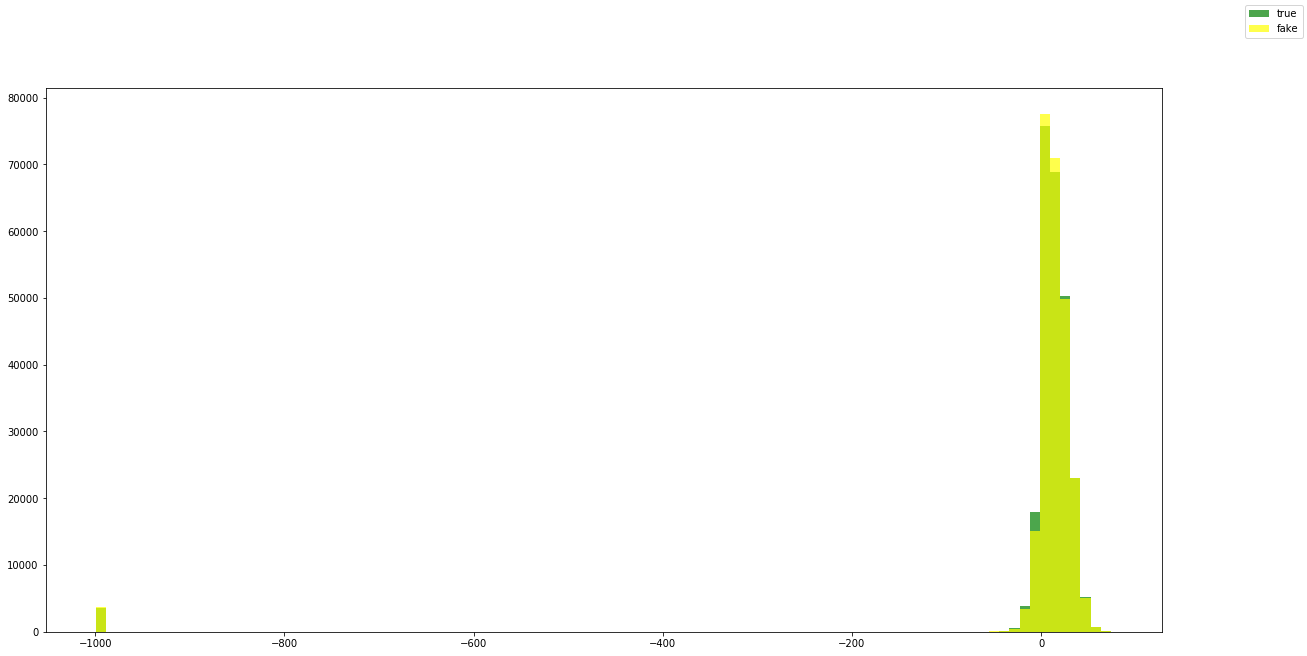

RichDLLk


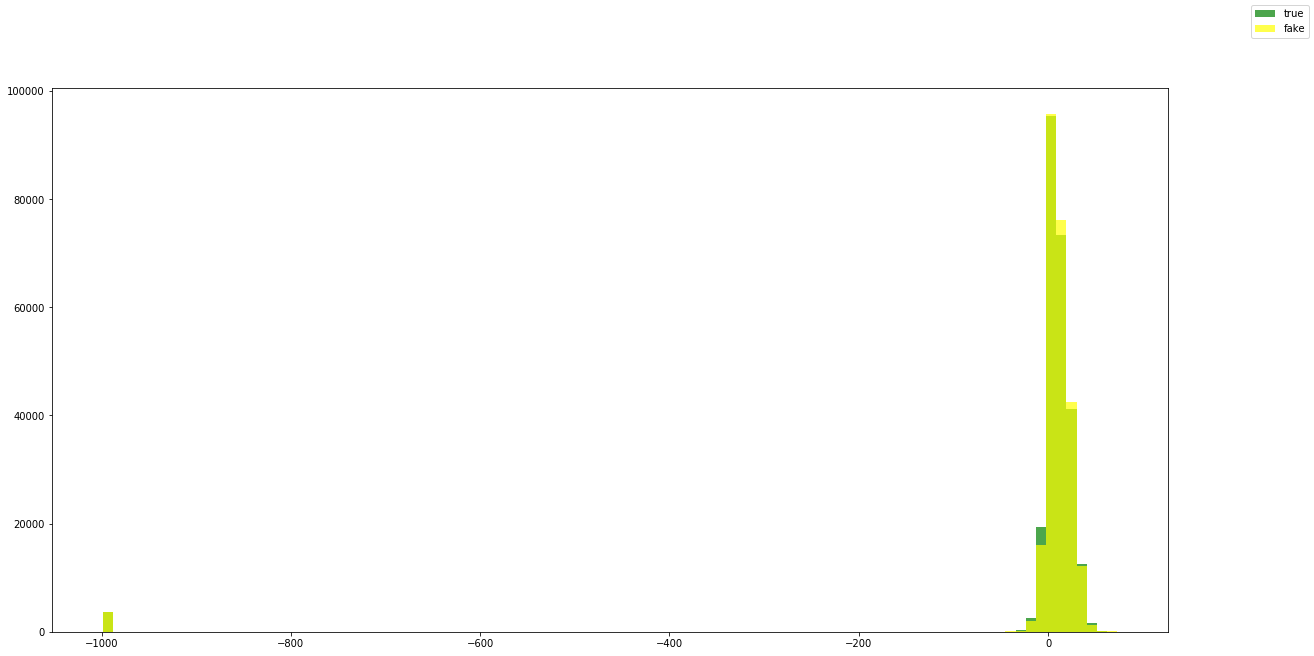

RichDLLmu


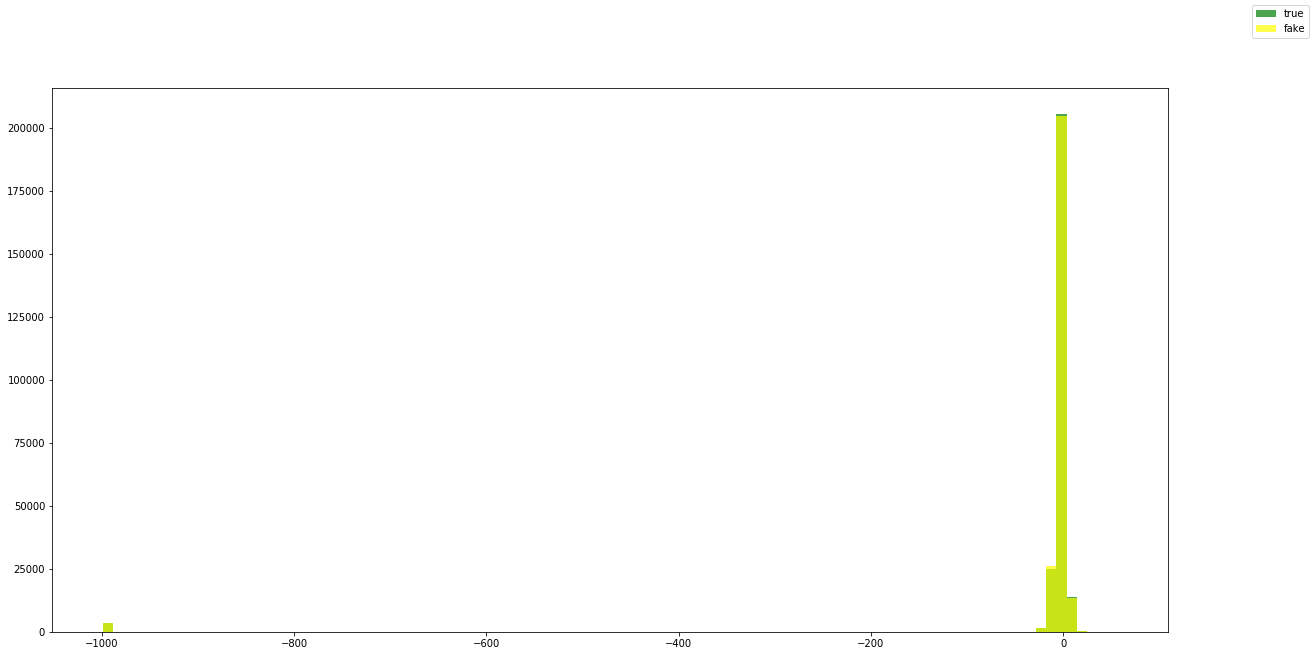

RichDLLp


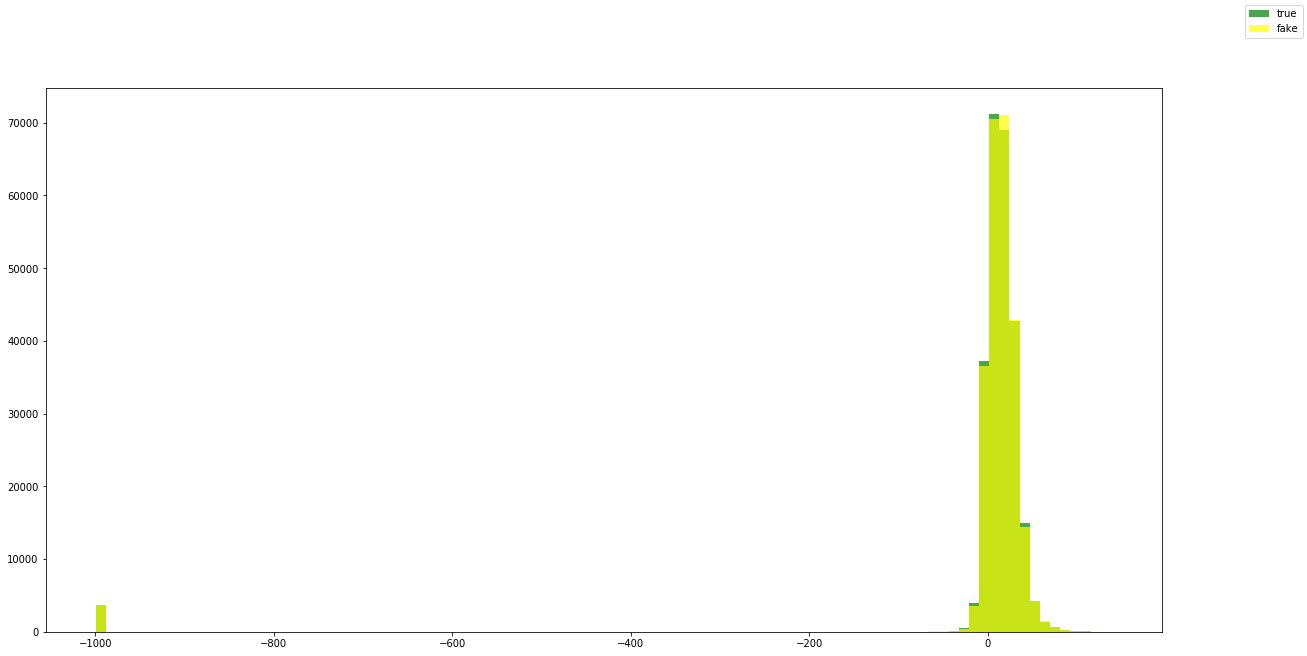

RichDLLe


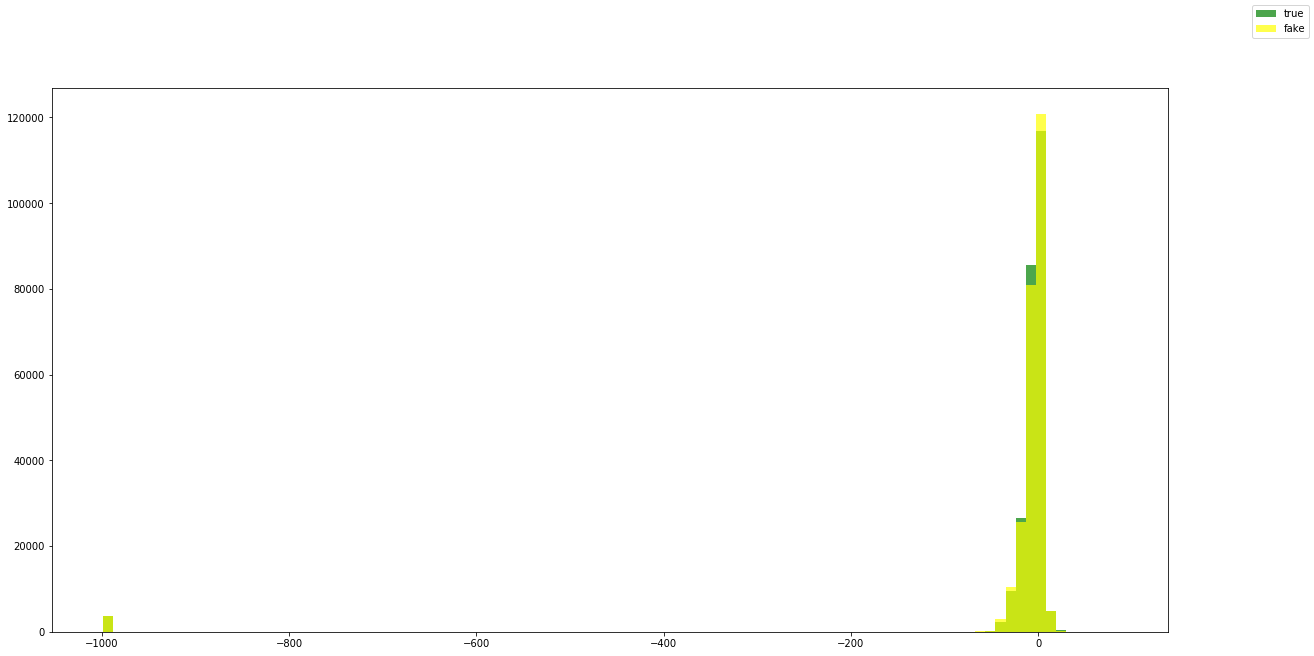


muon :  0.018563925744296994
RichDLLbt


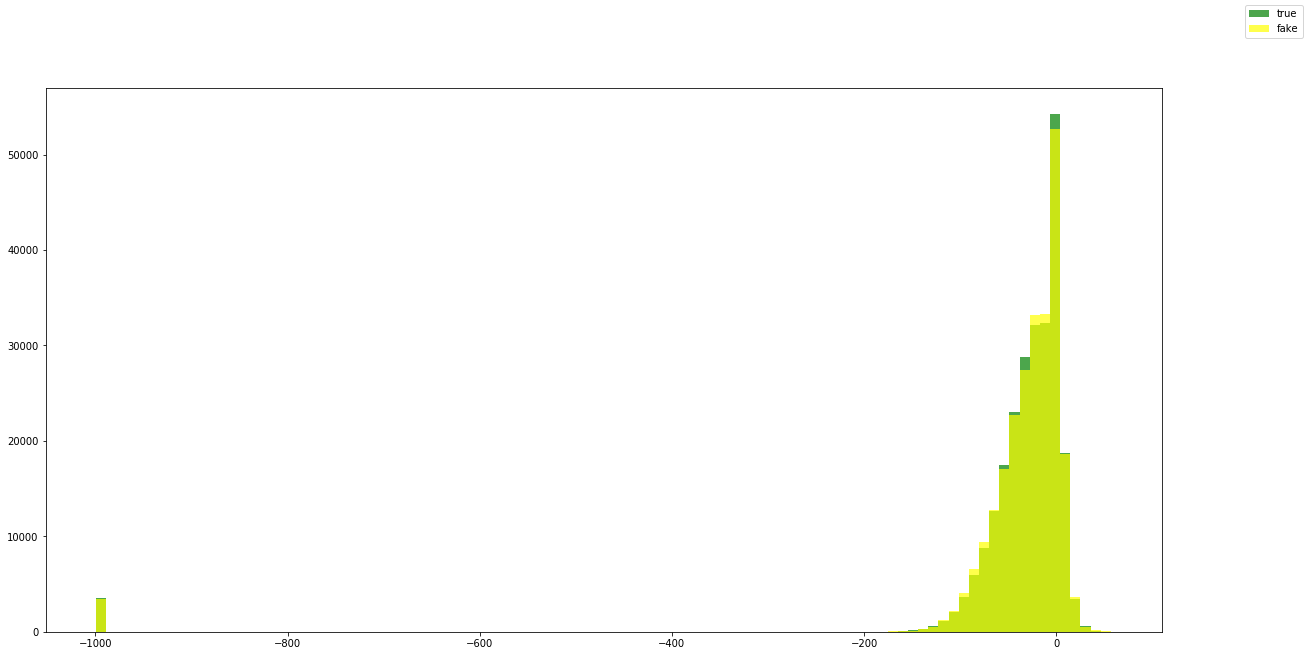

RichDLLk


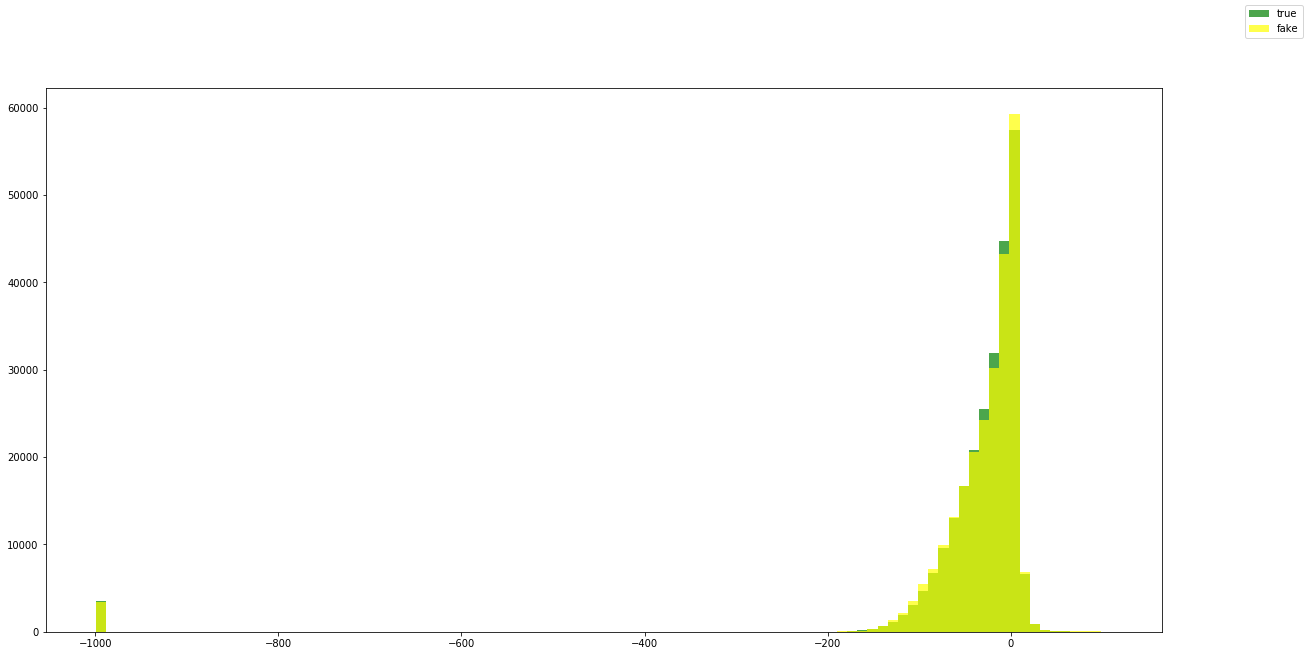

RichDLLmu


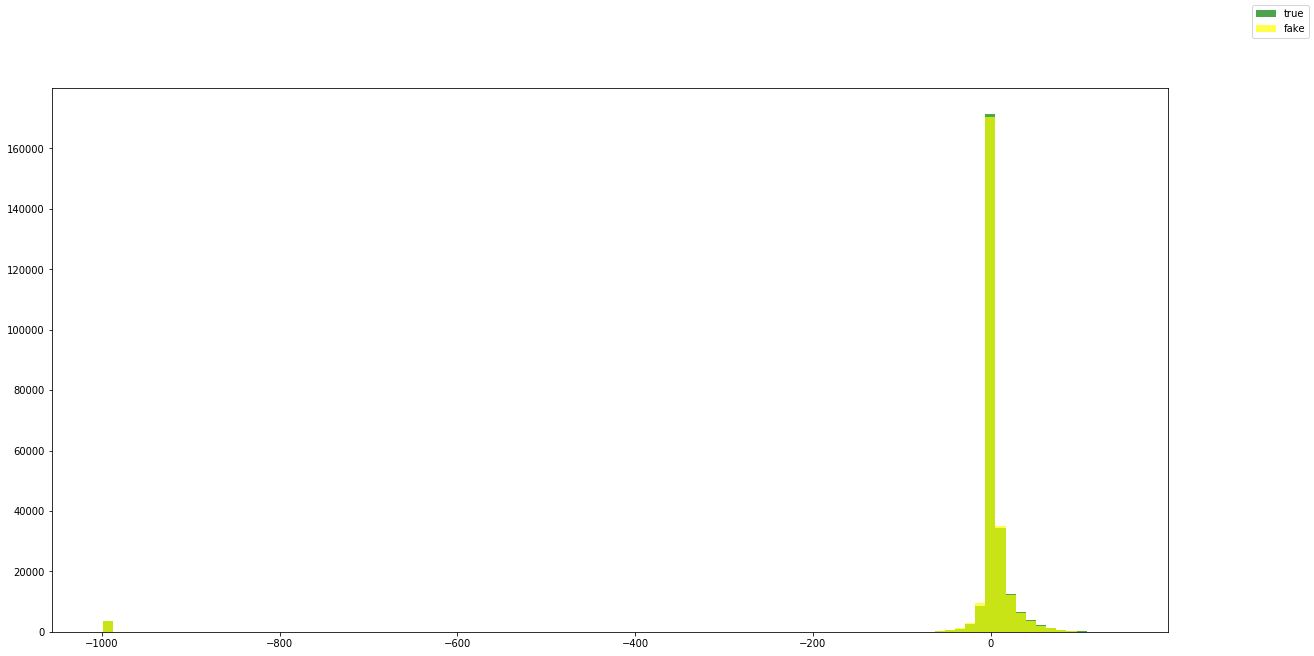

RichDLLp


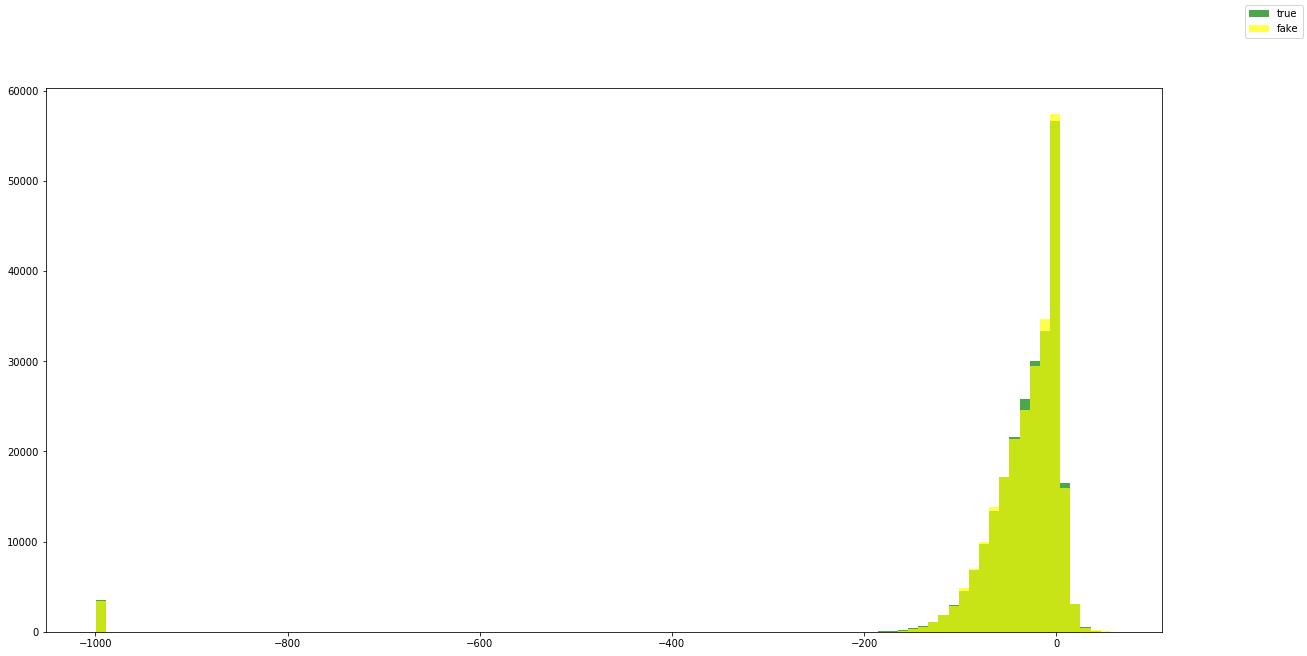

RichDLLe


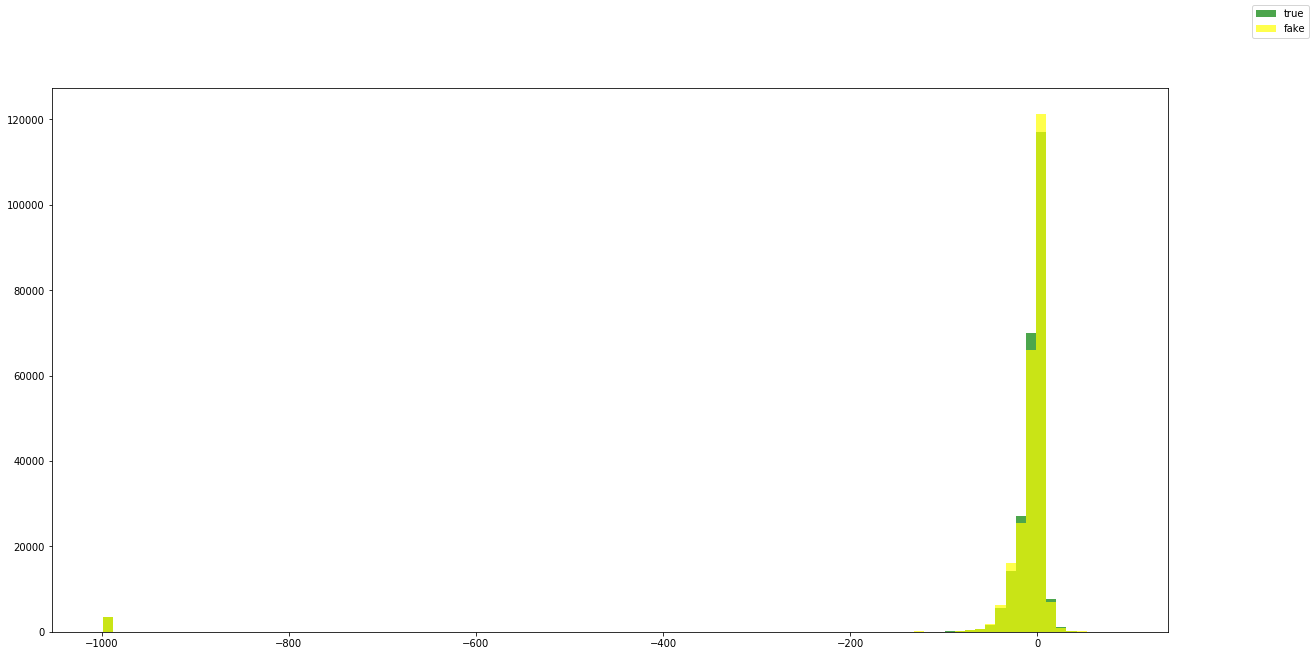


kaon :  0.014000056000223998
RichDLLbt


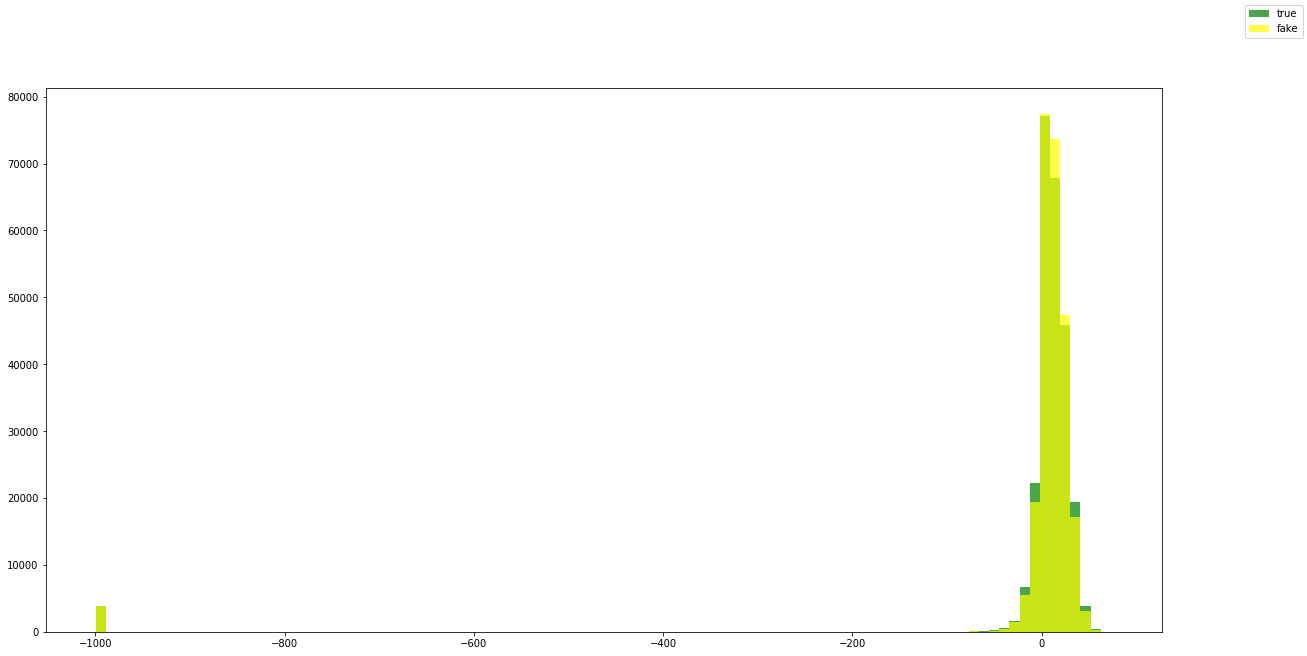

RichDLLk


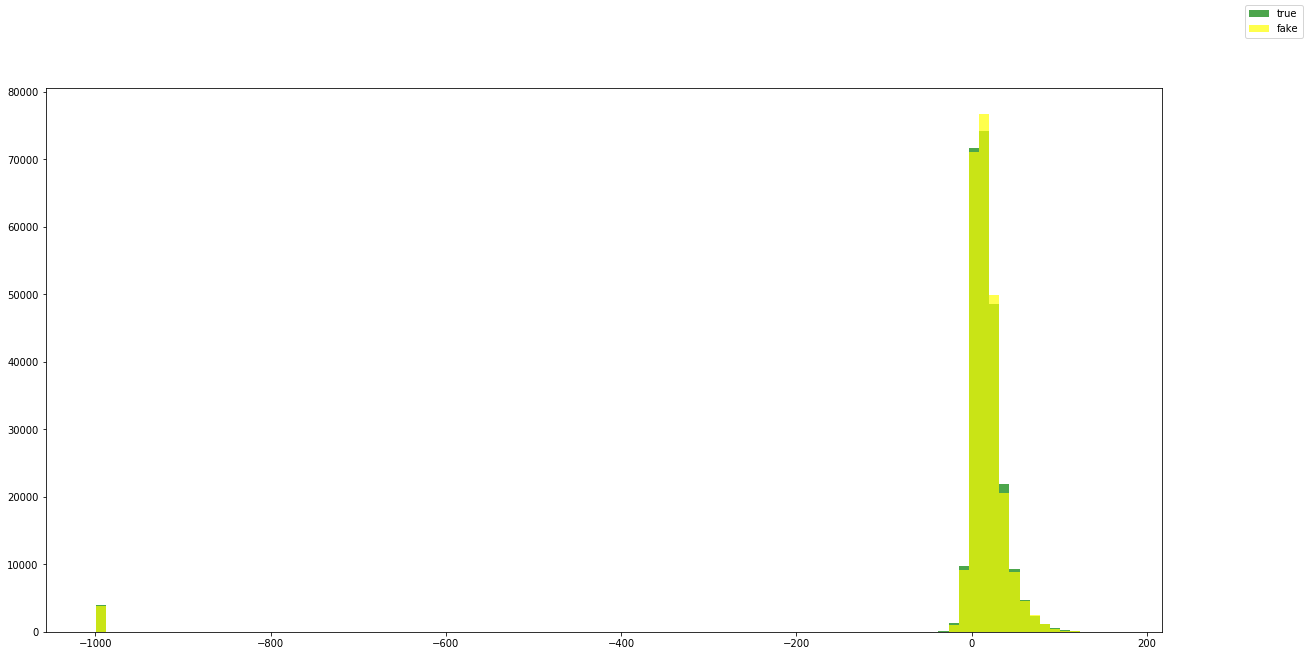

RichDLLmu


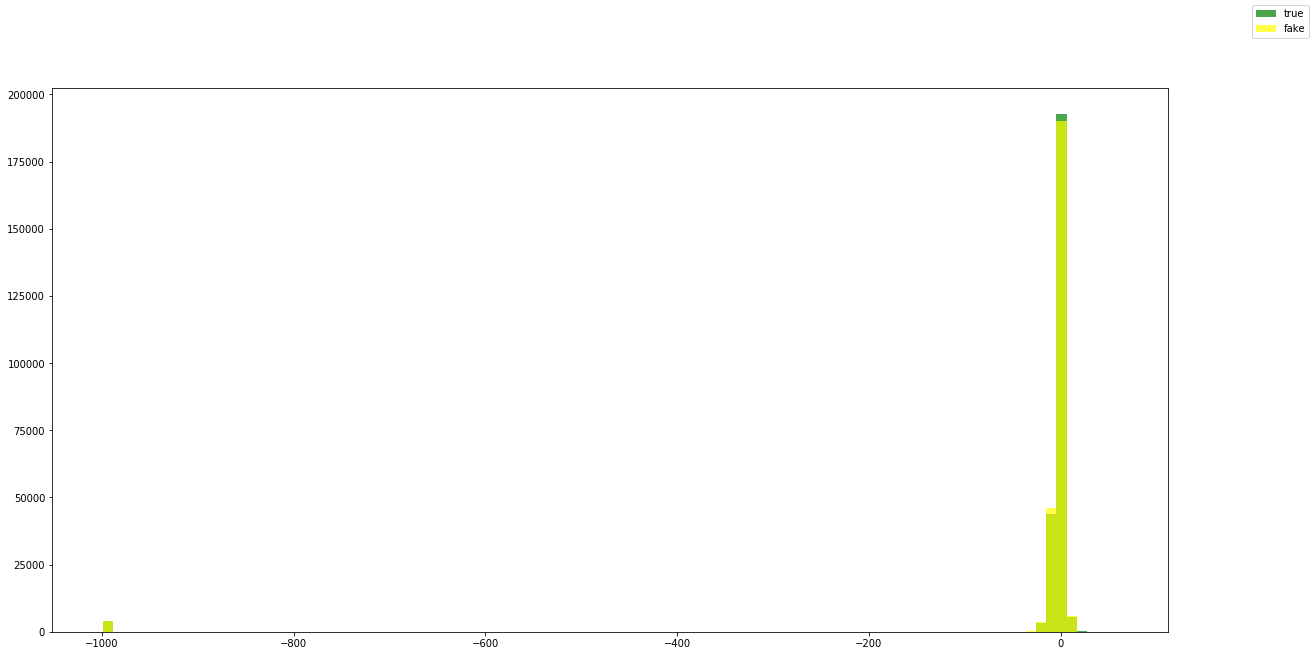

RichDLLp


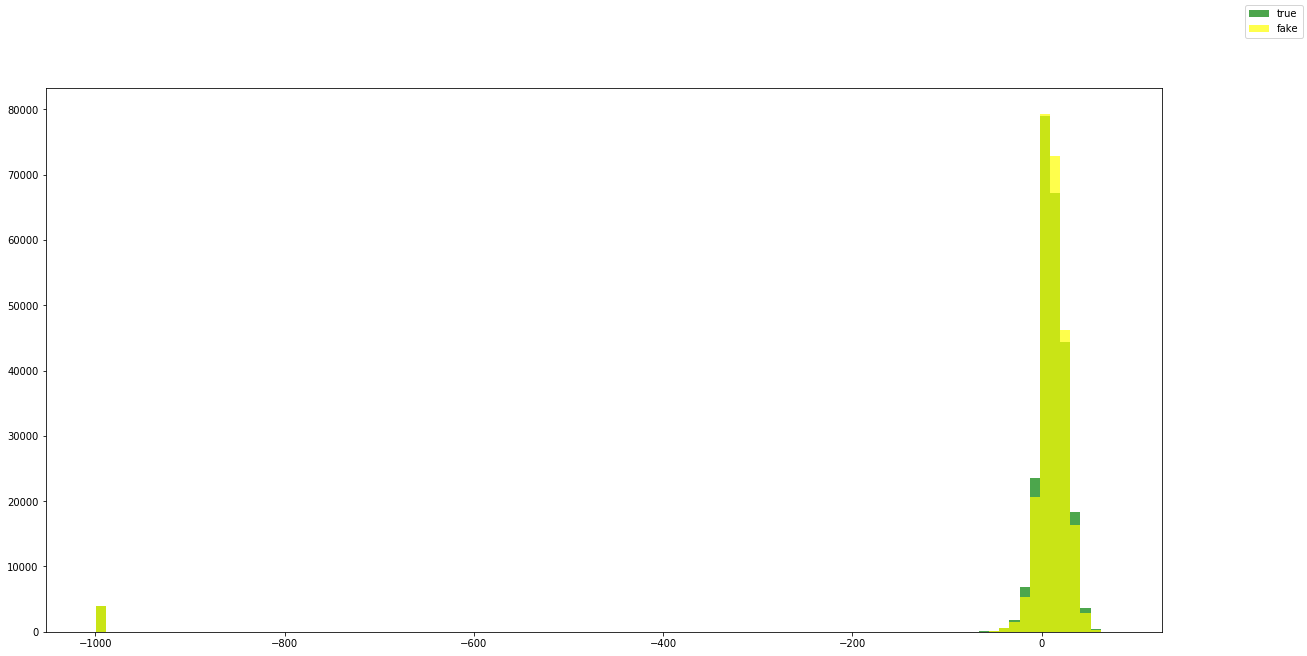

RichDLLe


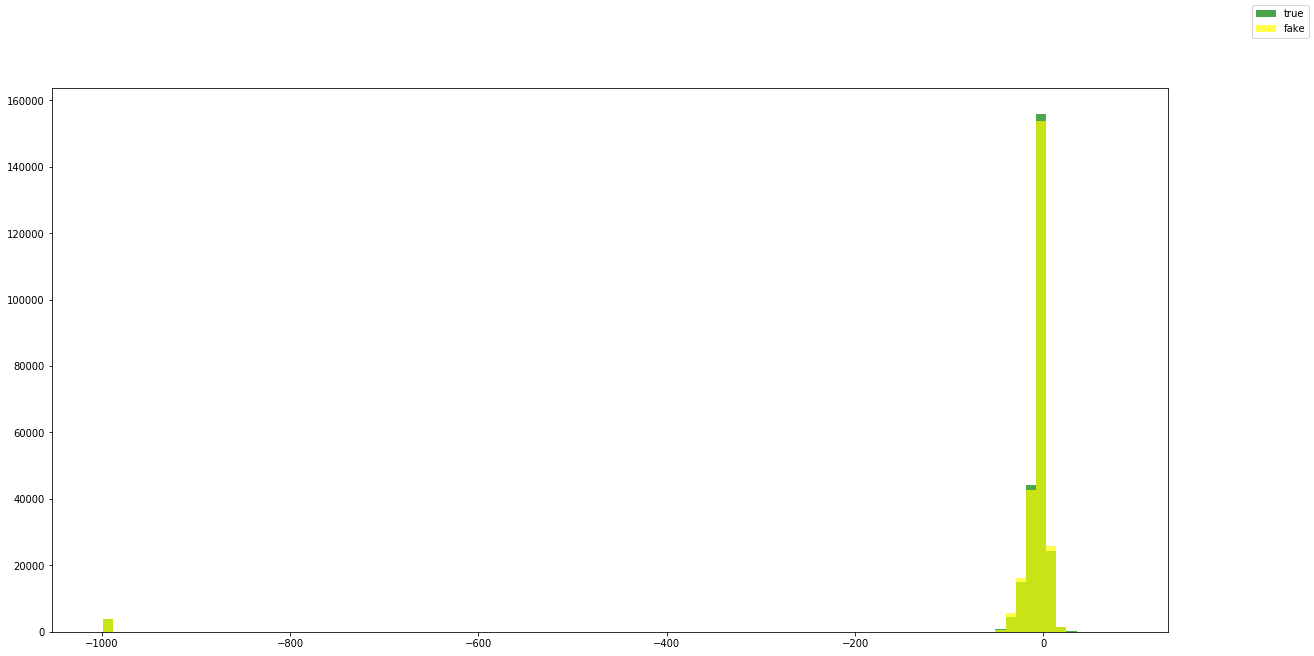


pion :  0.01368789049687602
RichDLLbt


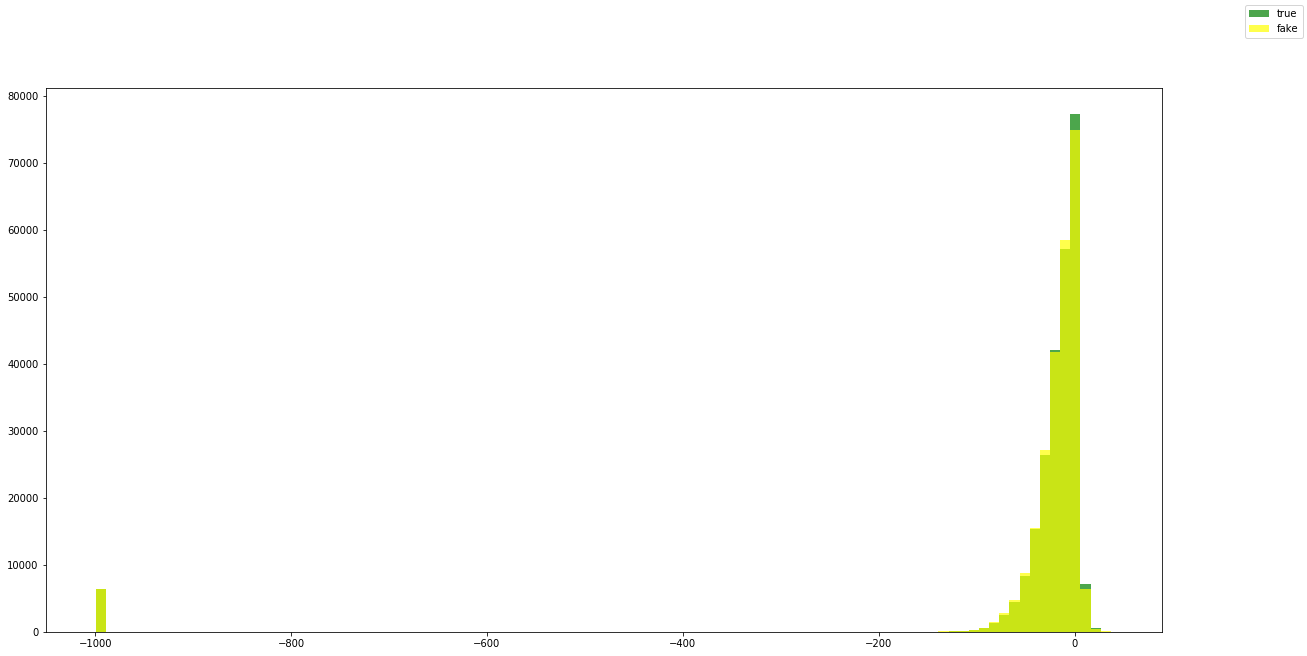

RichDLLk


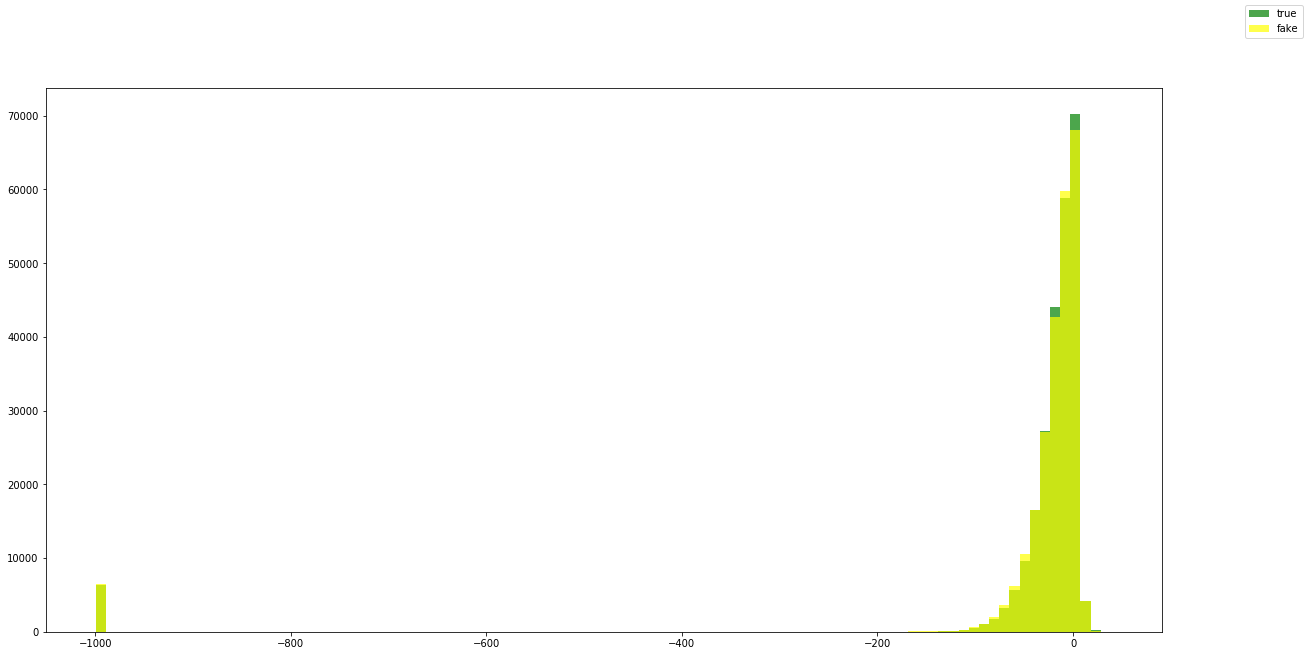

RichDLLmu


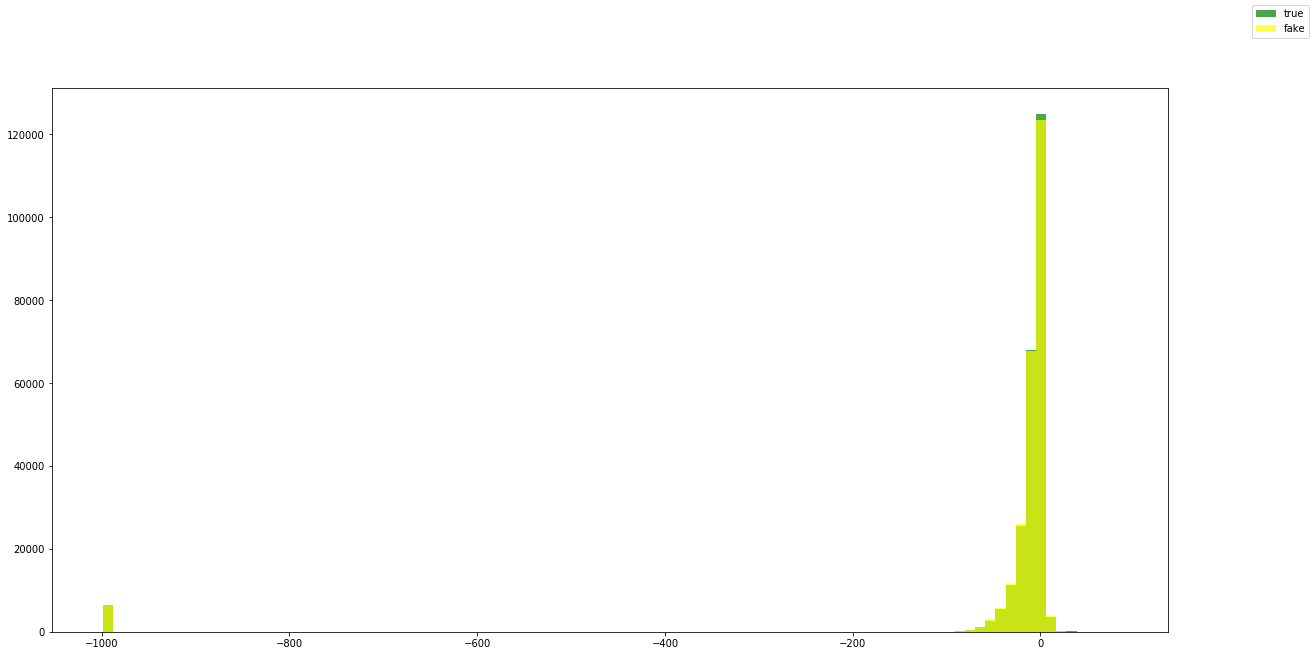

RichDLLp


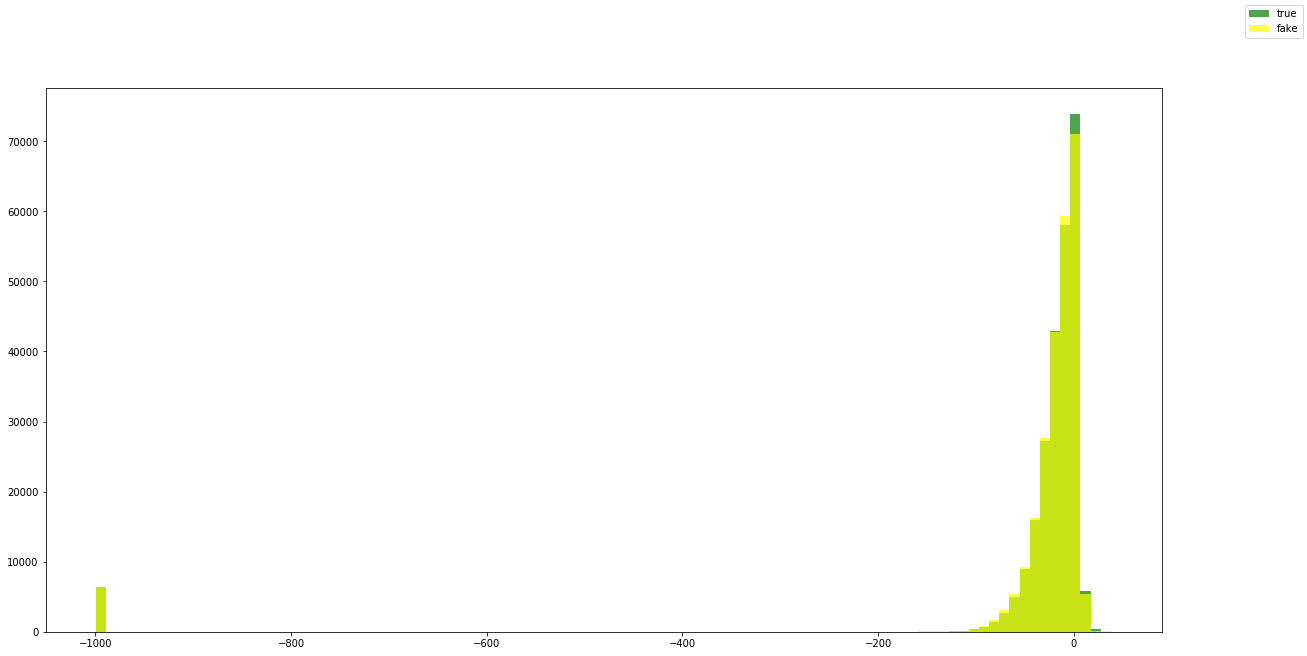

RichDLLe


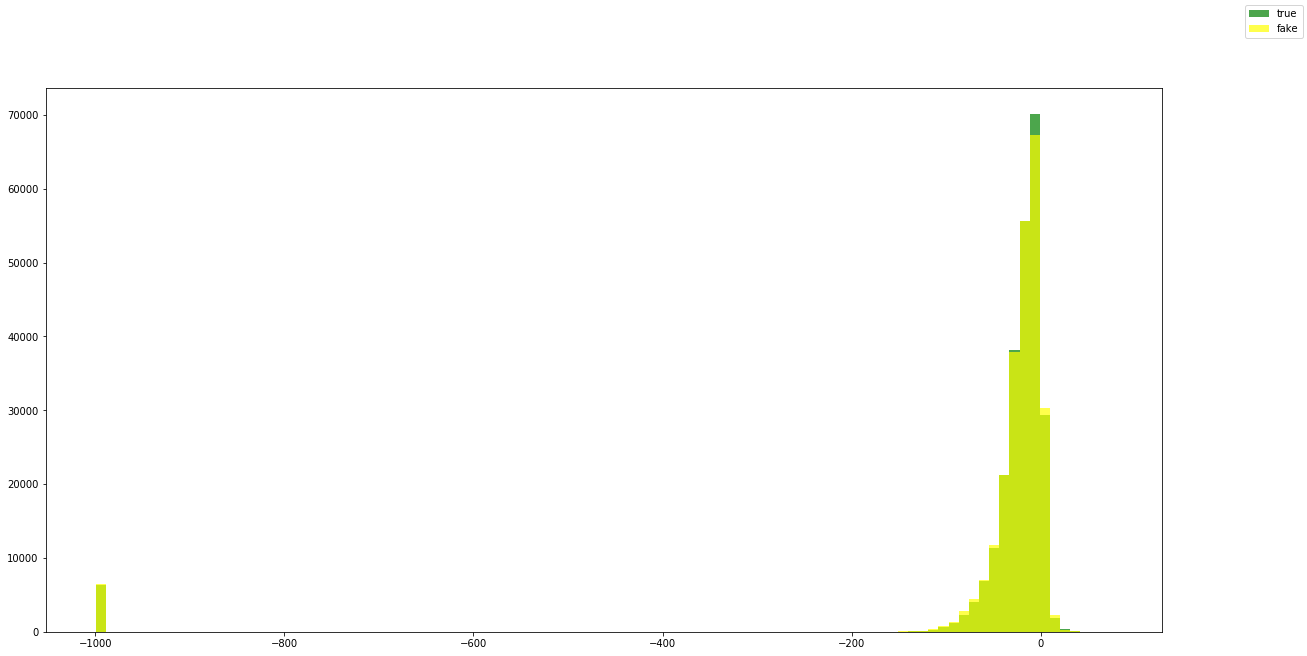

In [5]:
models = dict()
figs = defaultdict(dict)
scores = dict()

for particle in tqdm(['proton', 'muon', 'kaon', 'pion']):
    
    c_train = dataframes[particle]['train'][condition_cols]
    x_train = dataframes[particle]['train'][target_cols]
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    
    model = get_model()
    model.fit(
        c_train,
        x_train,
        start_epoch=0,
        num_epochs=50,
        n_critic=1,
        batch_size=512,
        writer=SummaryWriter(log_dir=Path(logdir, tag, particle)),
        num_workers=6,
    )
    models[particle] = model
    predicted = model.predict(c_test)
    reference = np.c_[x_test.values, c_test.values]
    generated = np.c_[predicted.values, c_test.values]
    score = score_func(generated, reference, n_slices=1000)
    scores[particle] = score
    print(particle, ': ', score)
    for col in target_cols:
        print(col)
        fig = plot_hist(x_test[col].values, predicted[col].values)
        figs[particle][col] = fig
        display(fig)
    print('='*100)
        

proton :  0.010516318355054621
RichDLLbt


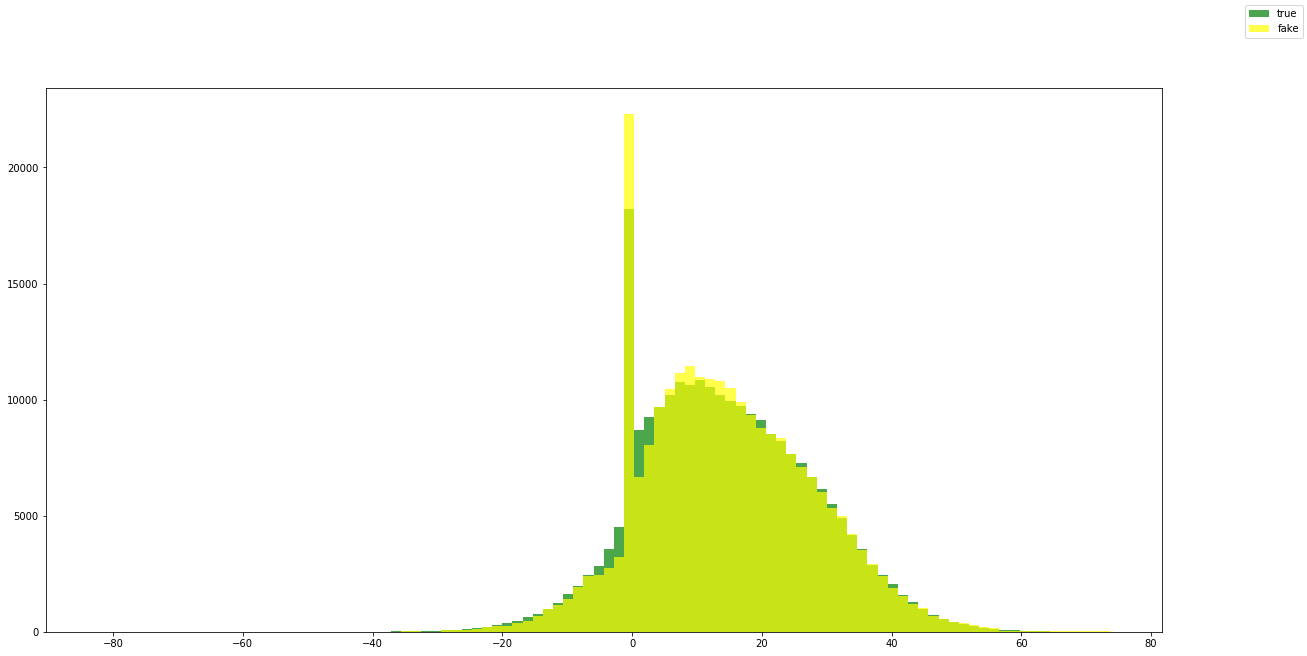

RichDLLk


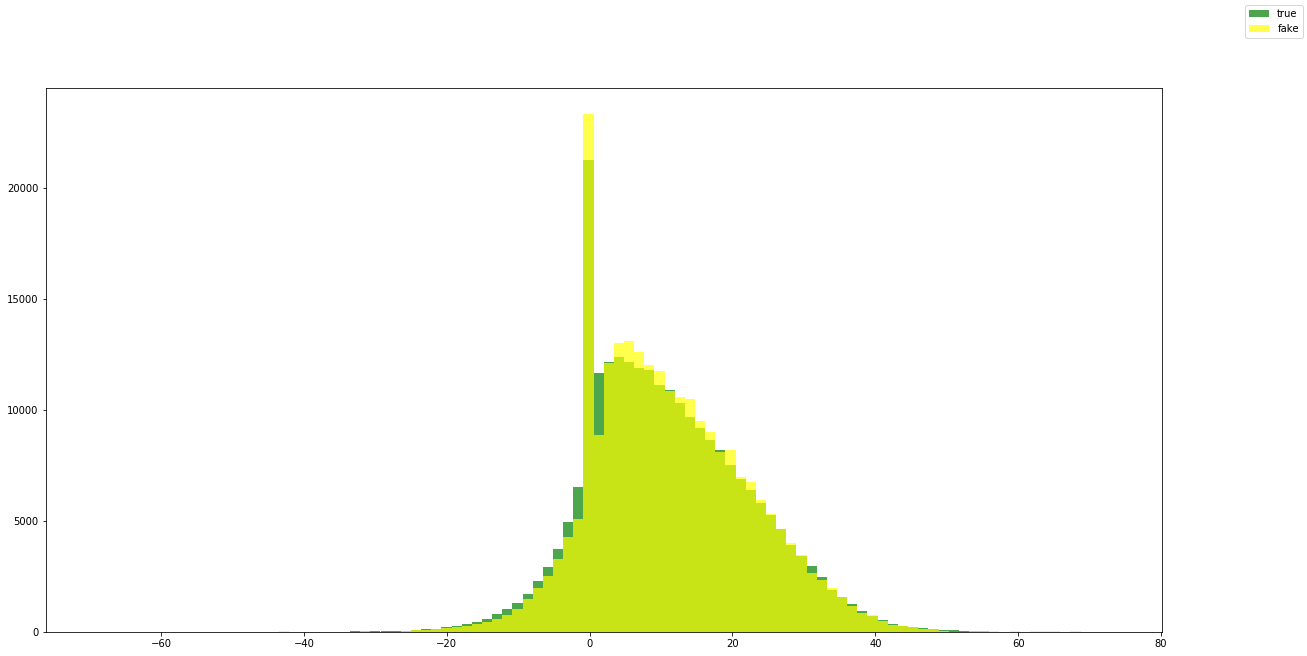

RichDLLmu


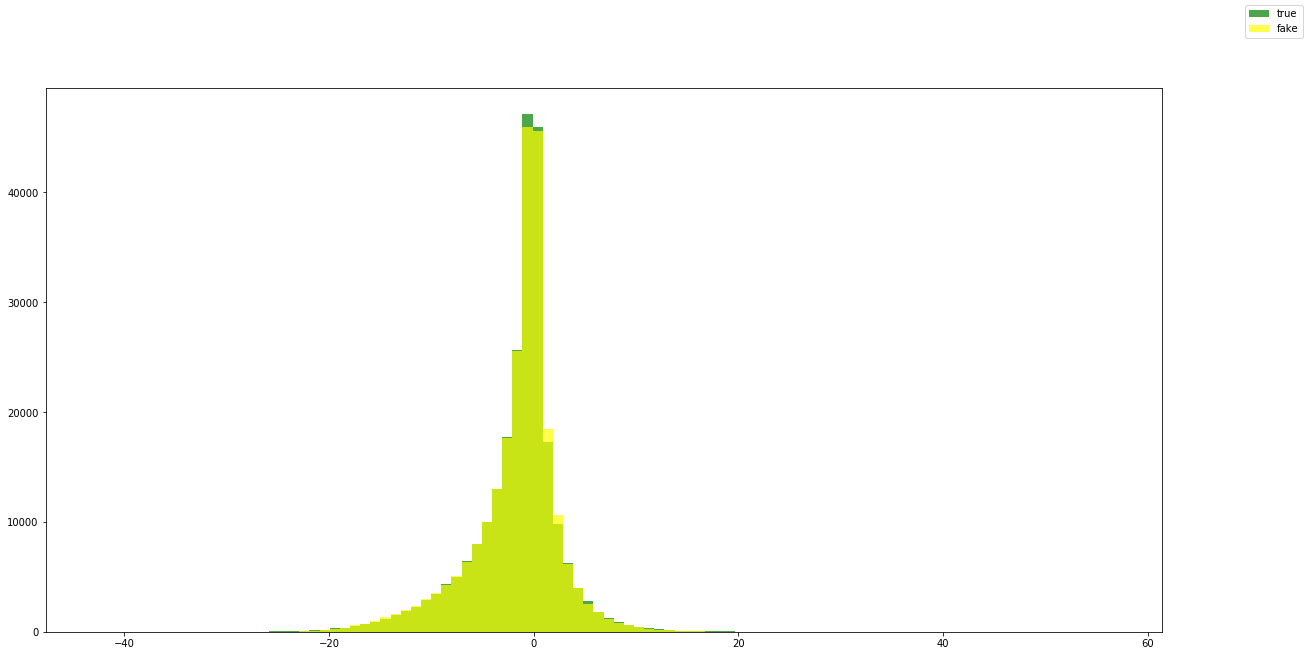

RichDLLp


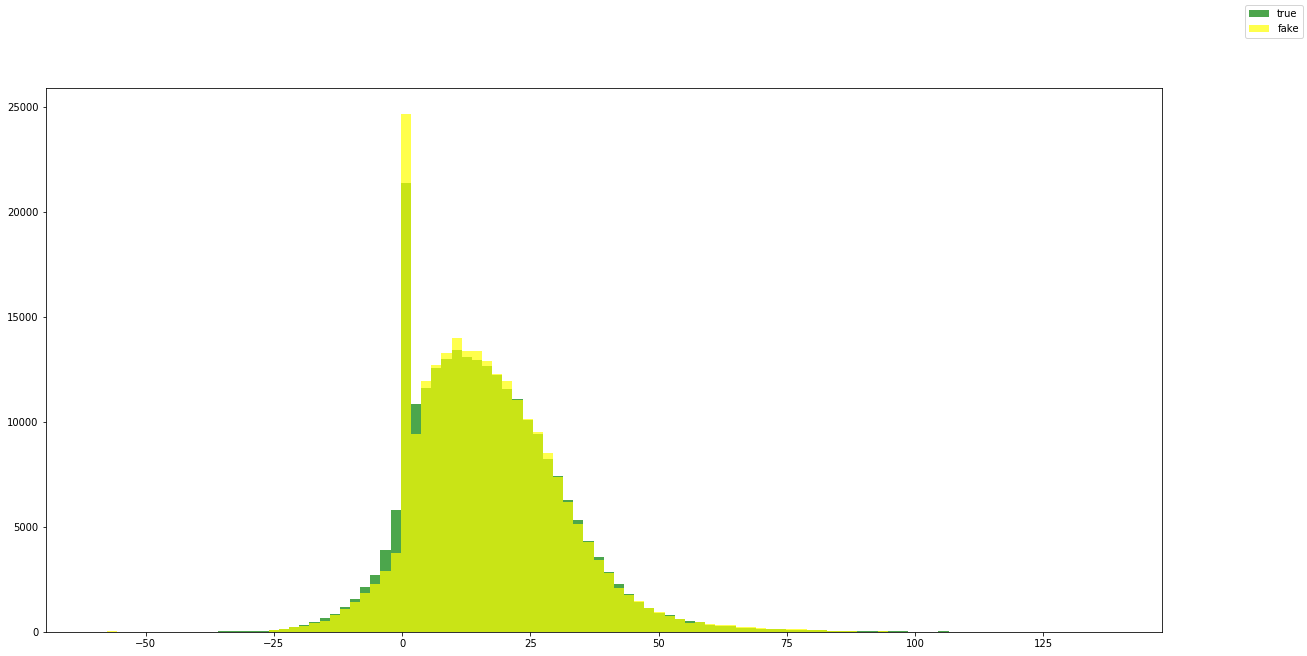

RichDLLe


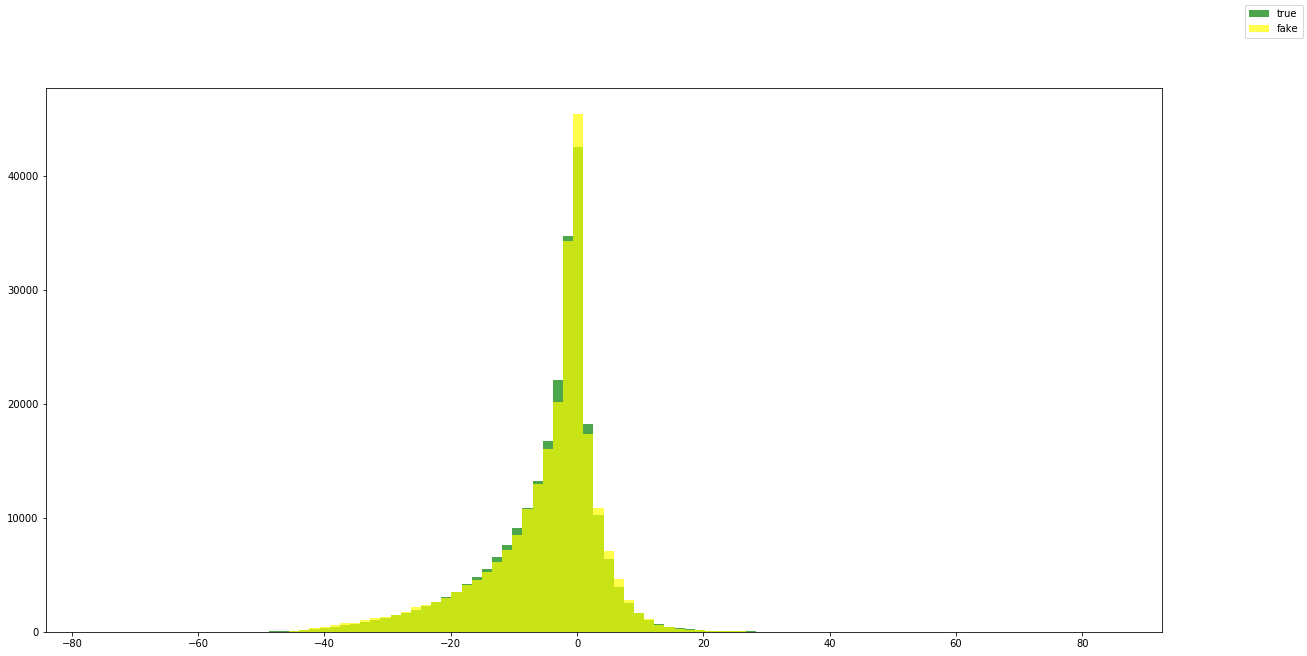

muon :  0.016798198454078817
RichDLLbt


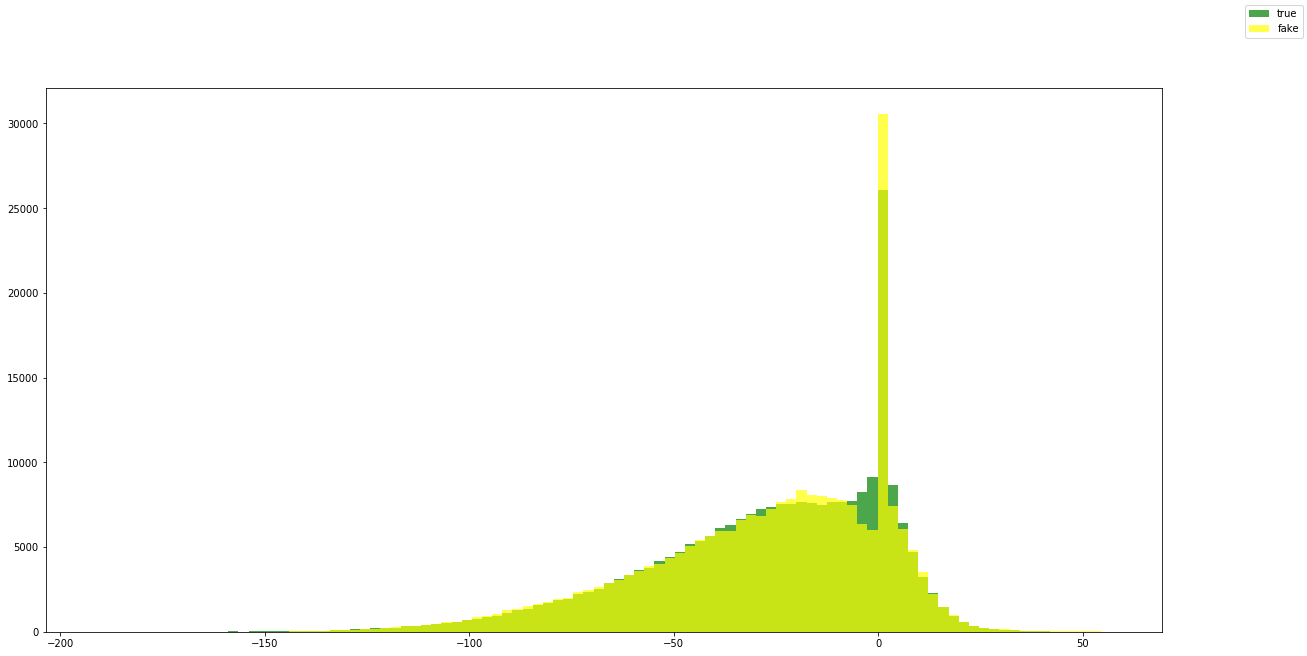

RichDLLk


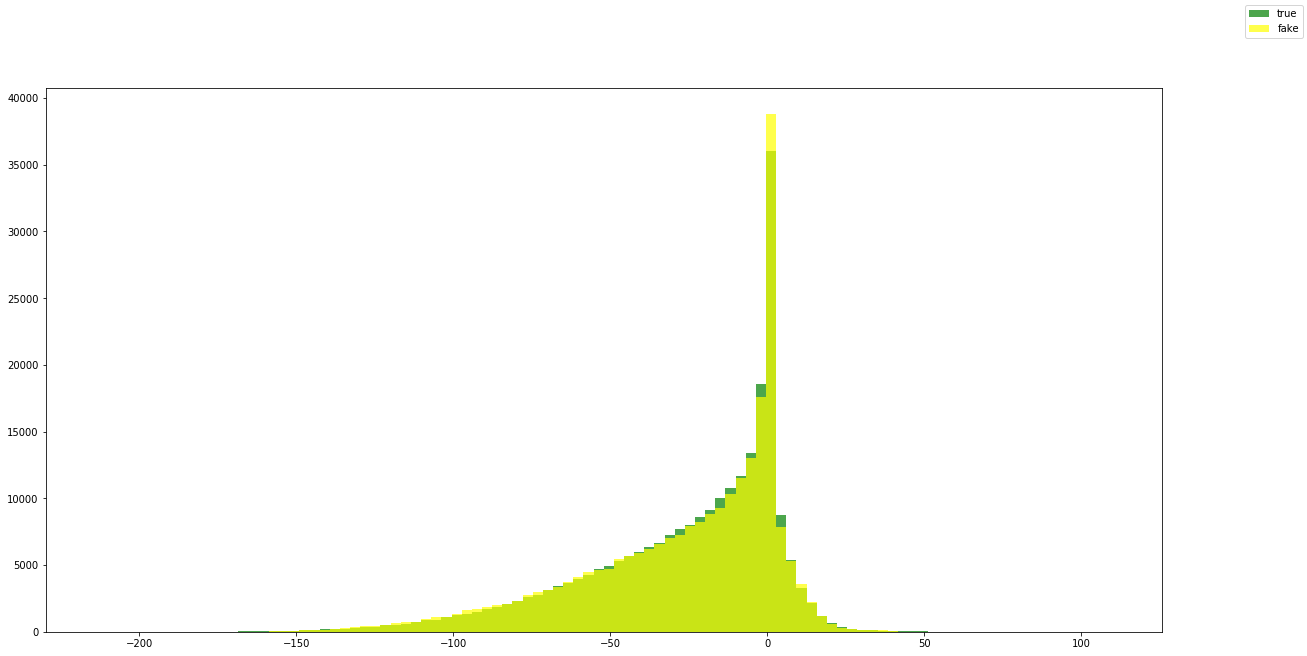

RichDLLmu


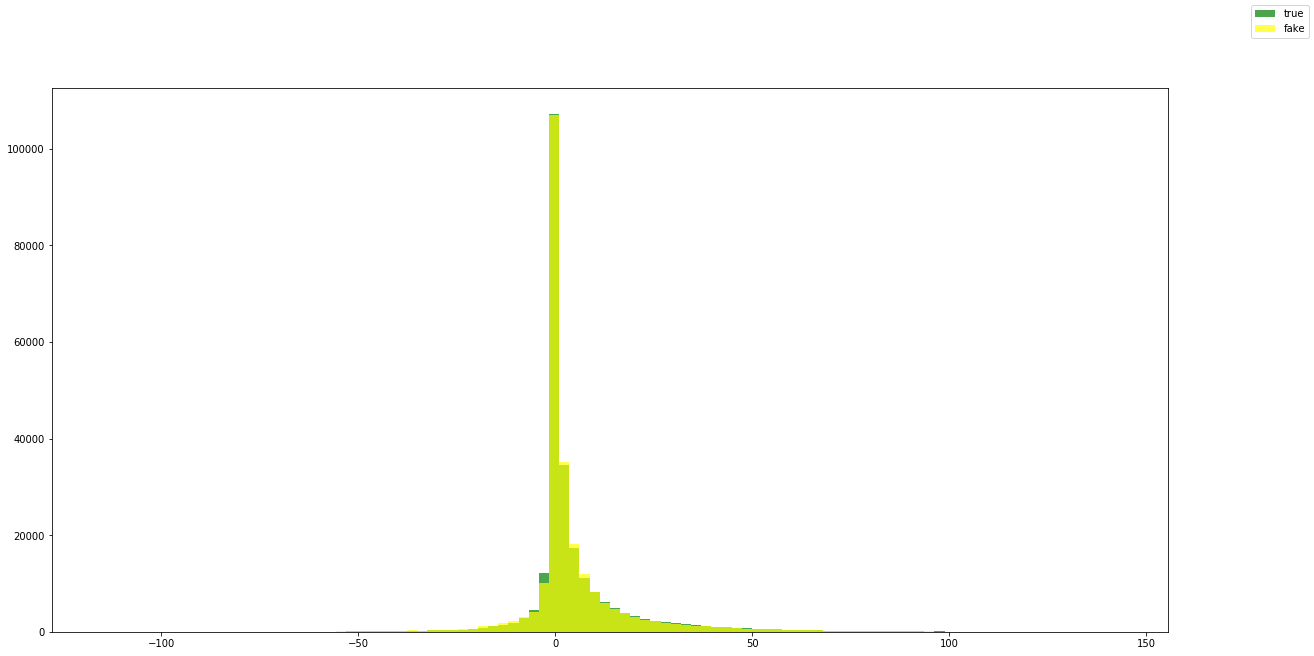

RichDLLp


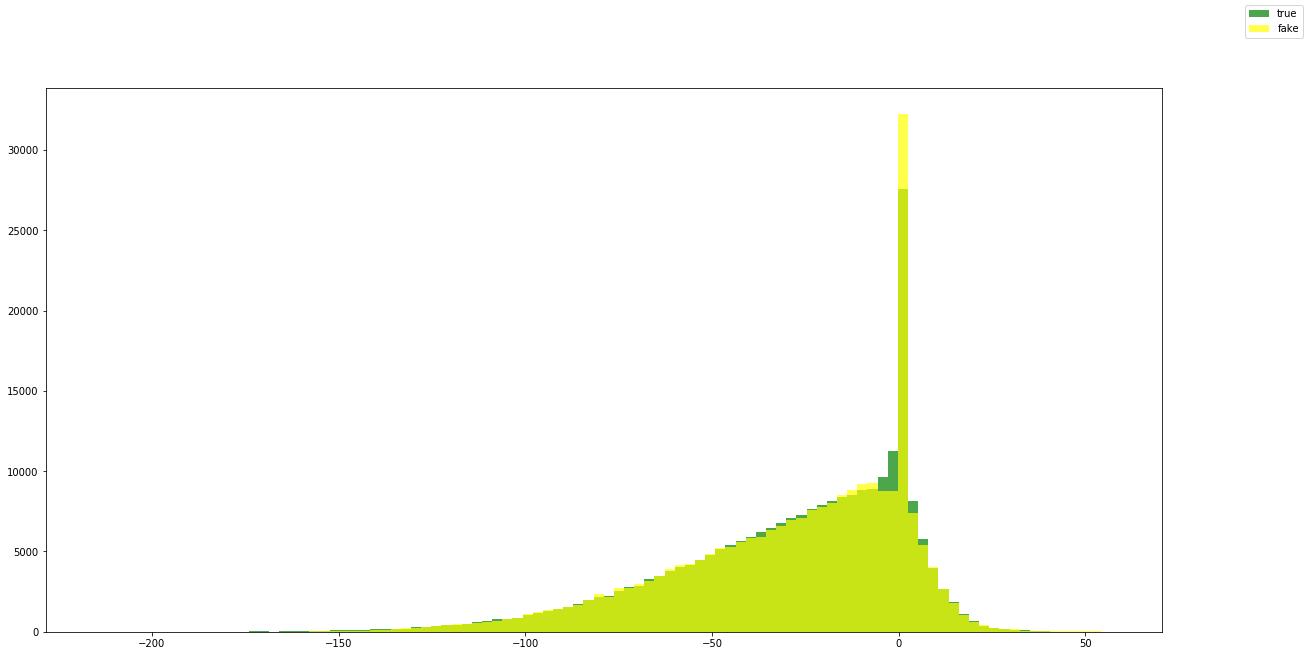

RichDLLe


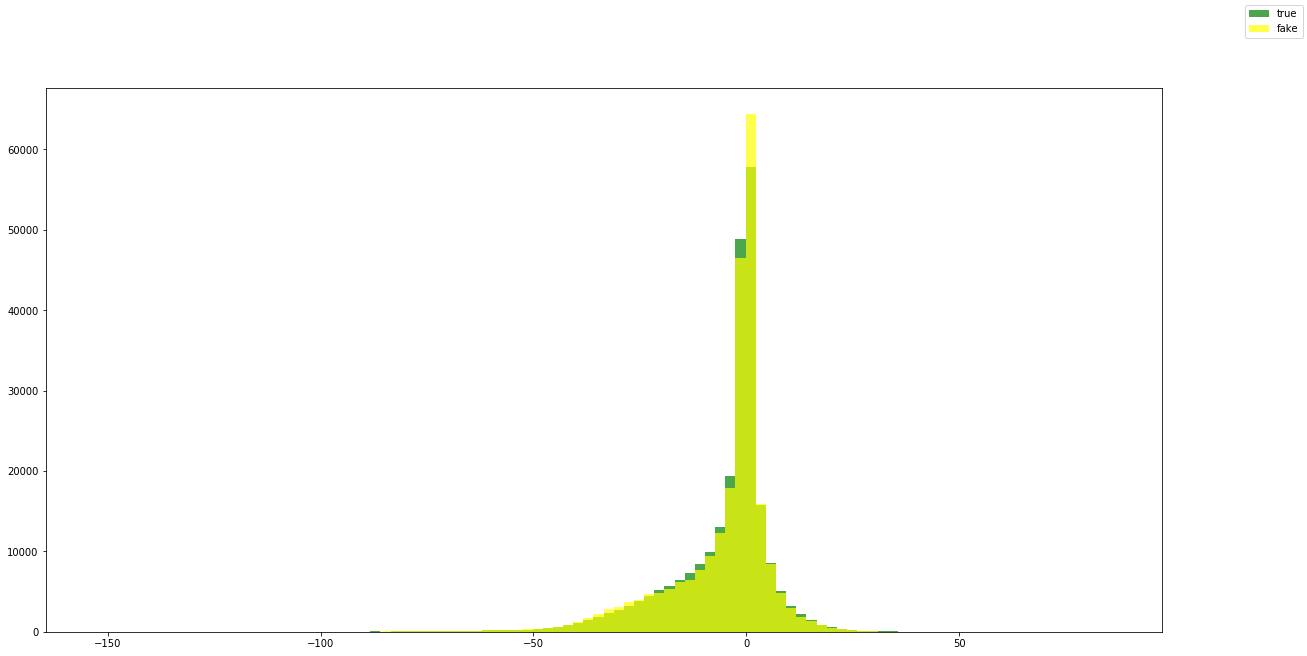

kaon :  0.01232430850998989
RichDLLbt


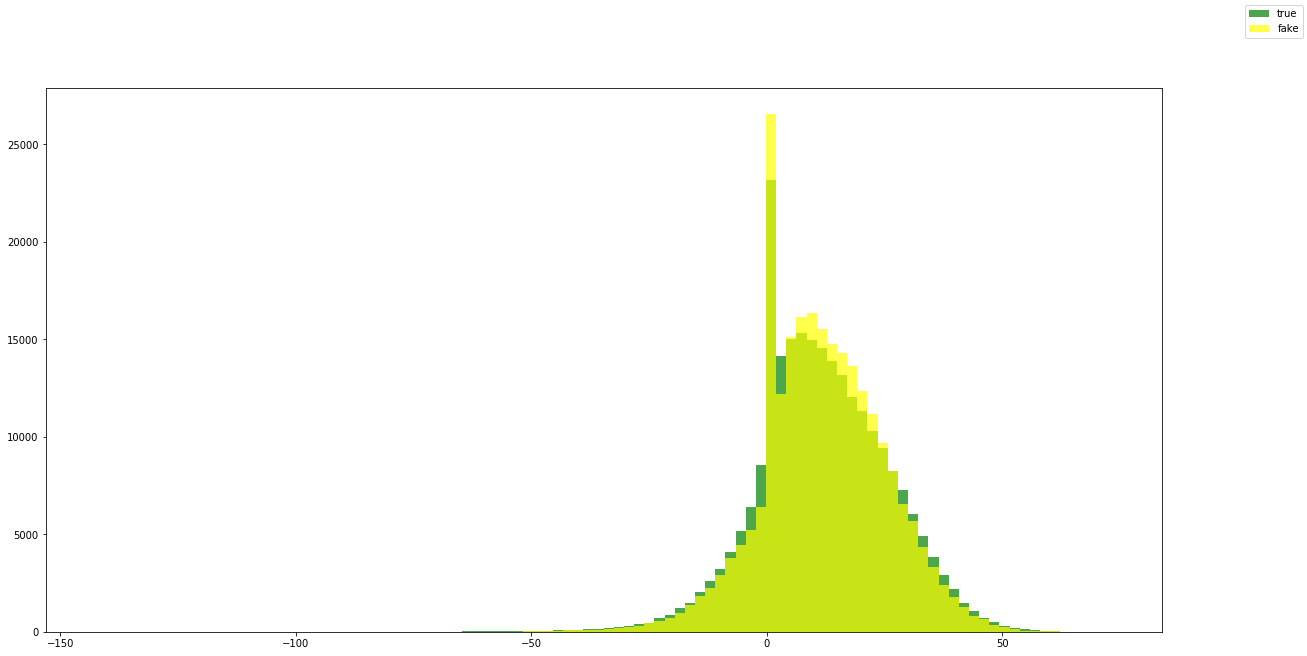

RichDLLk


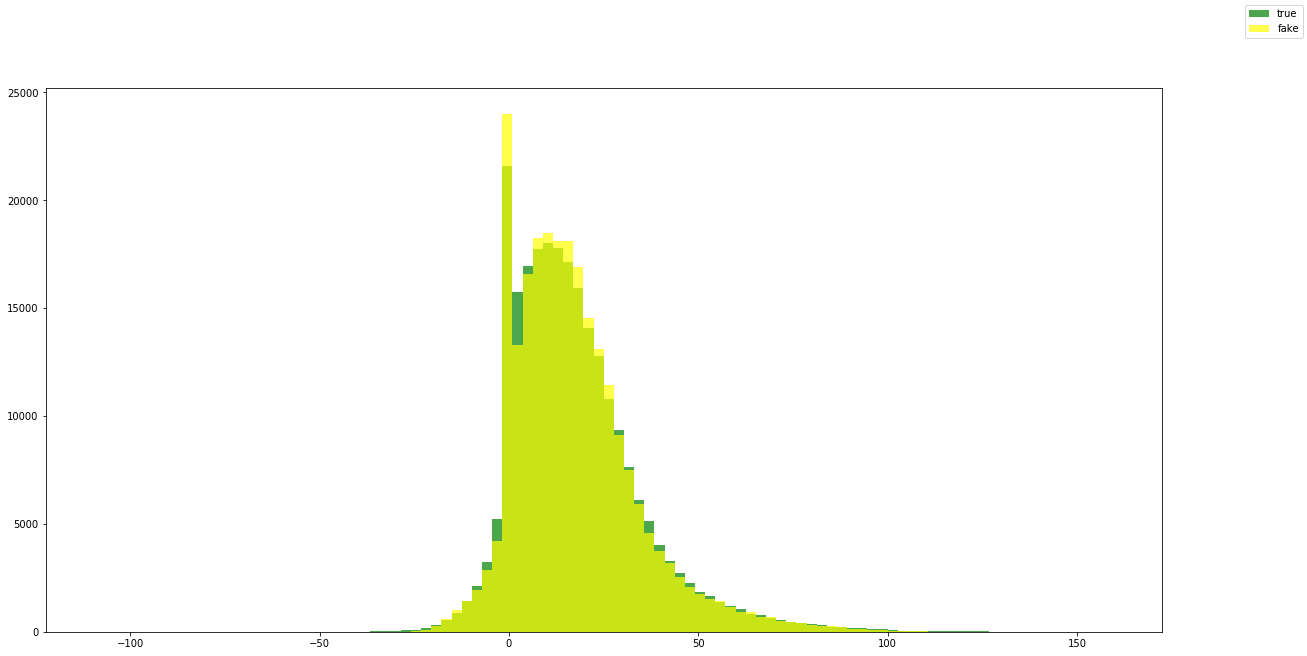

RichDLLmu


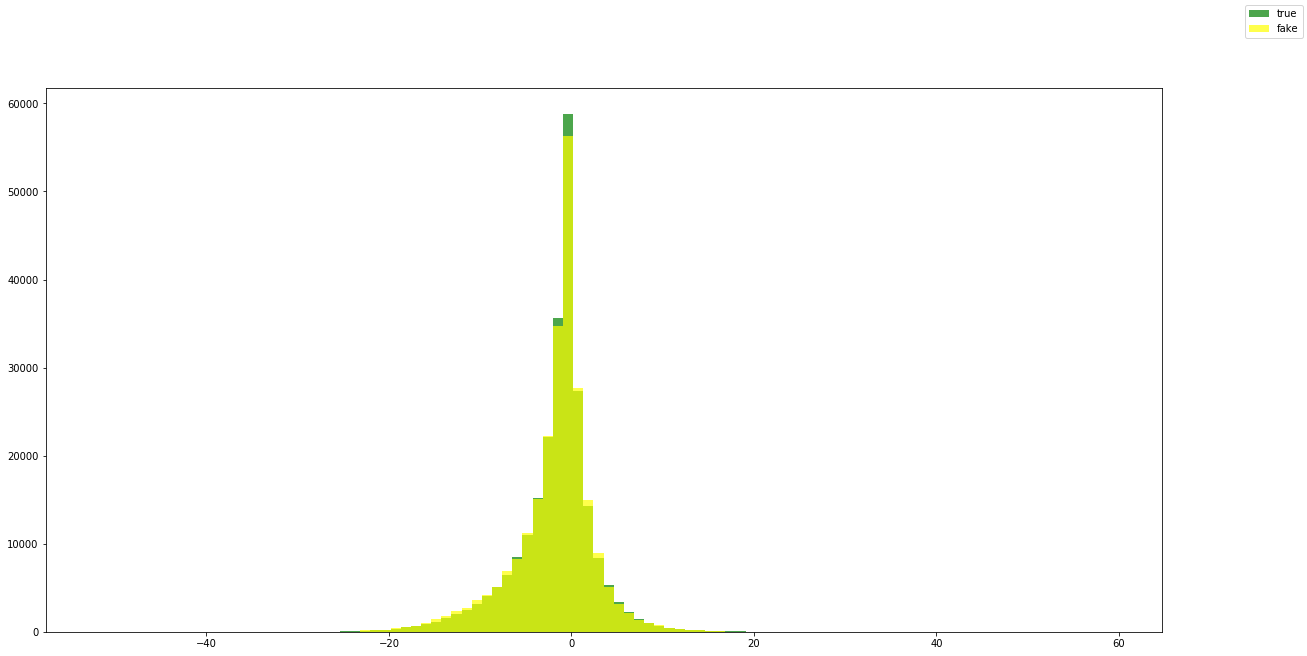

RichDLLp


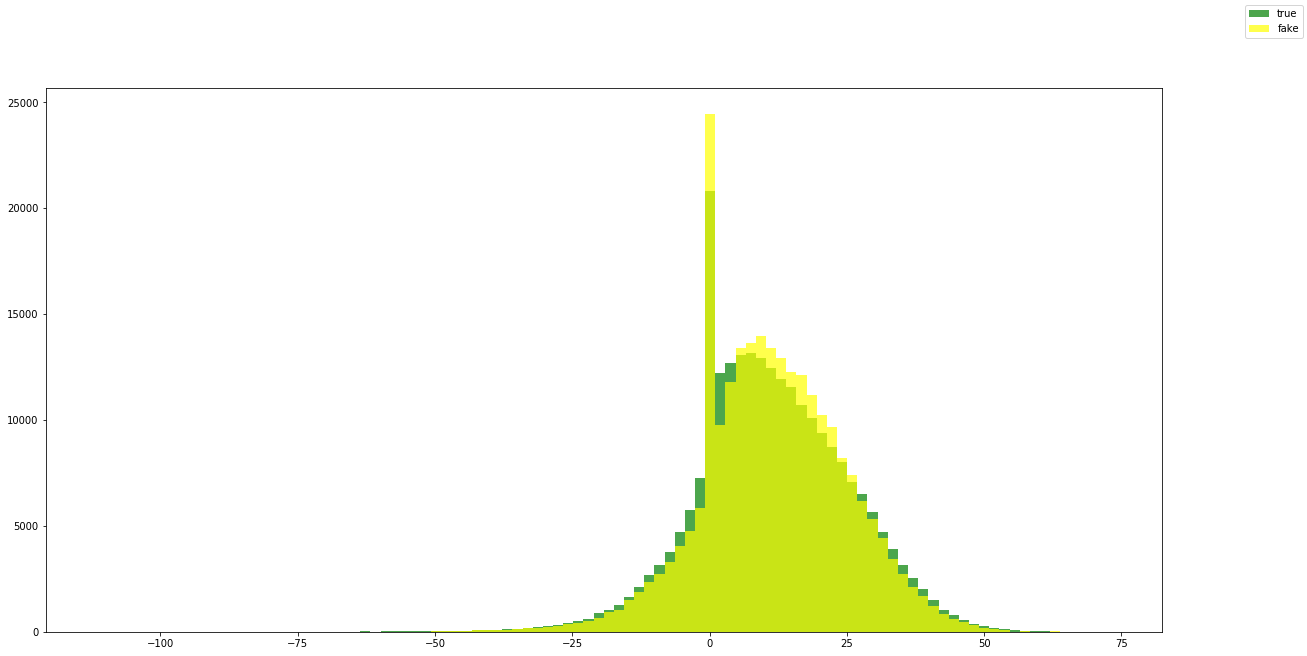

RichDLLe


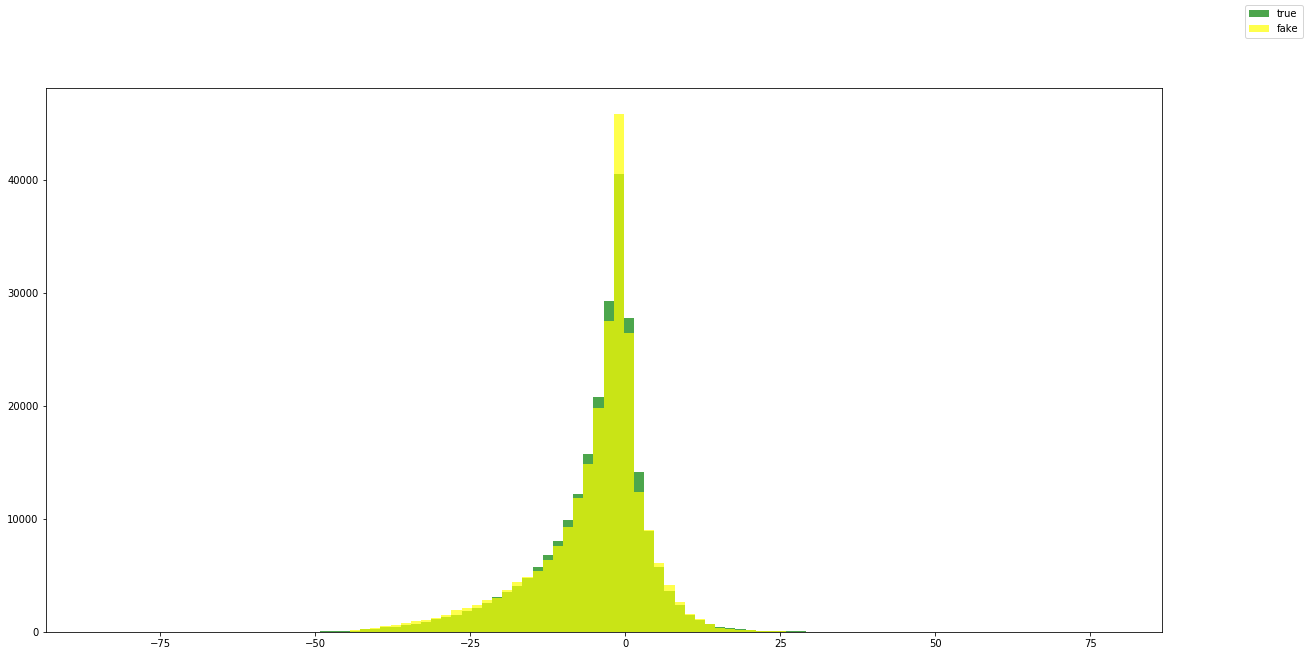

pion :  0.015389983579638777
RichDLLbt


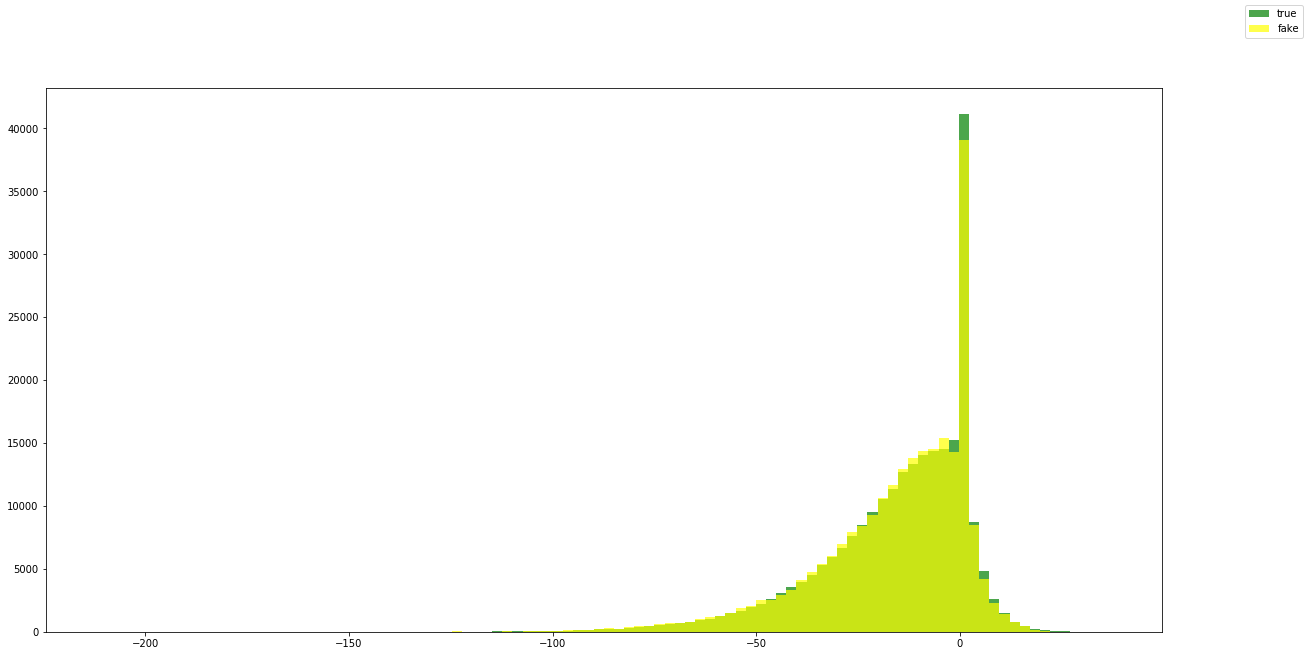

RichDLLk


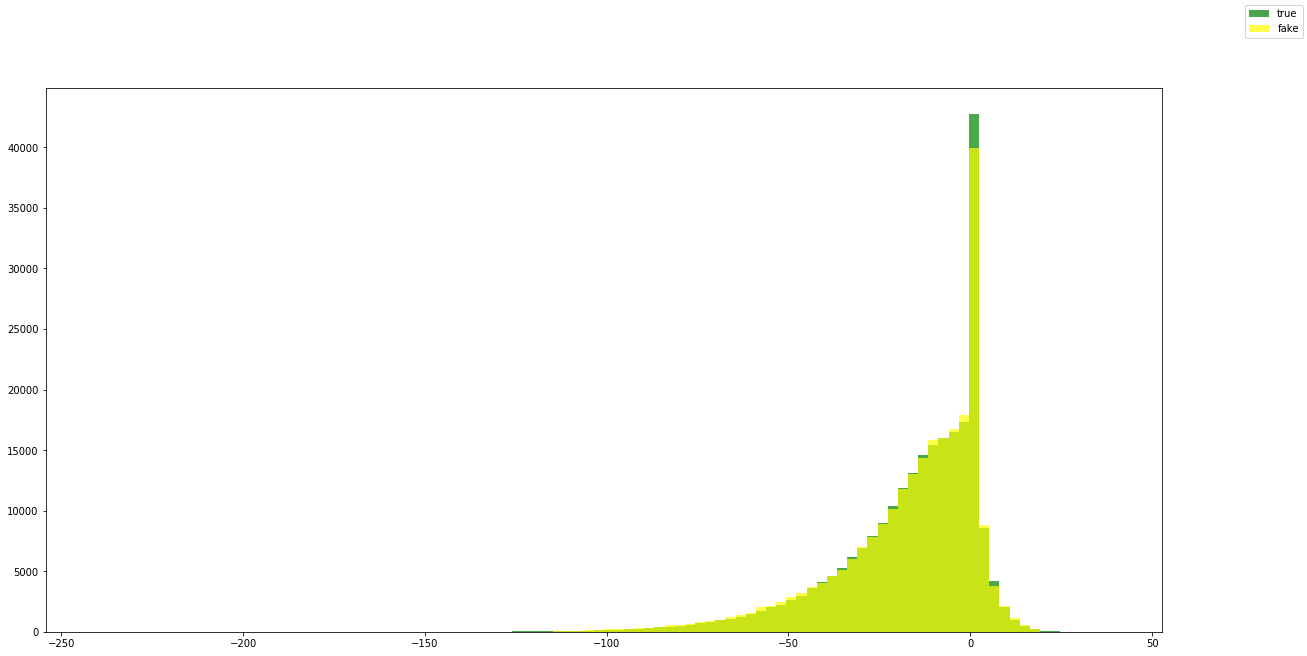

RichDLLmu


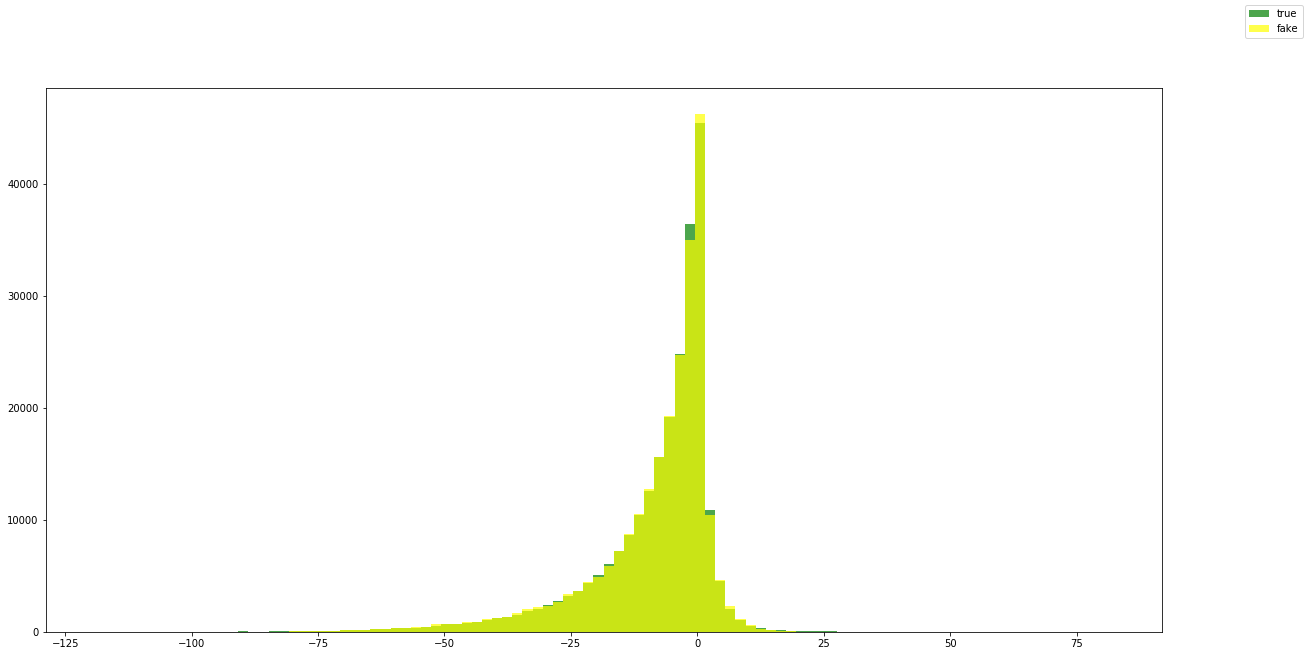

RichDLLp


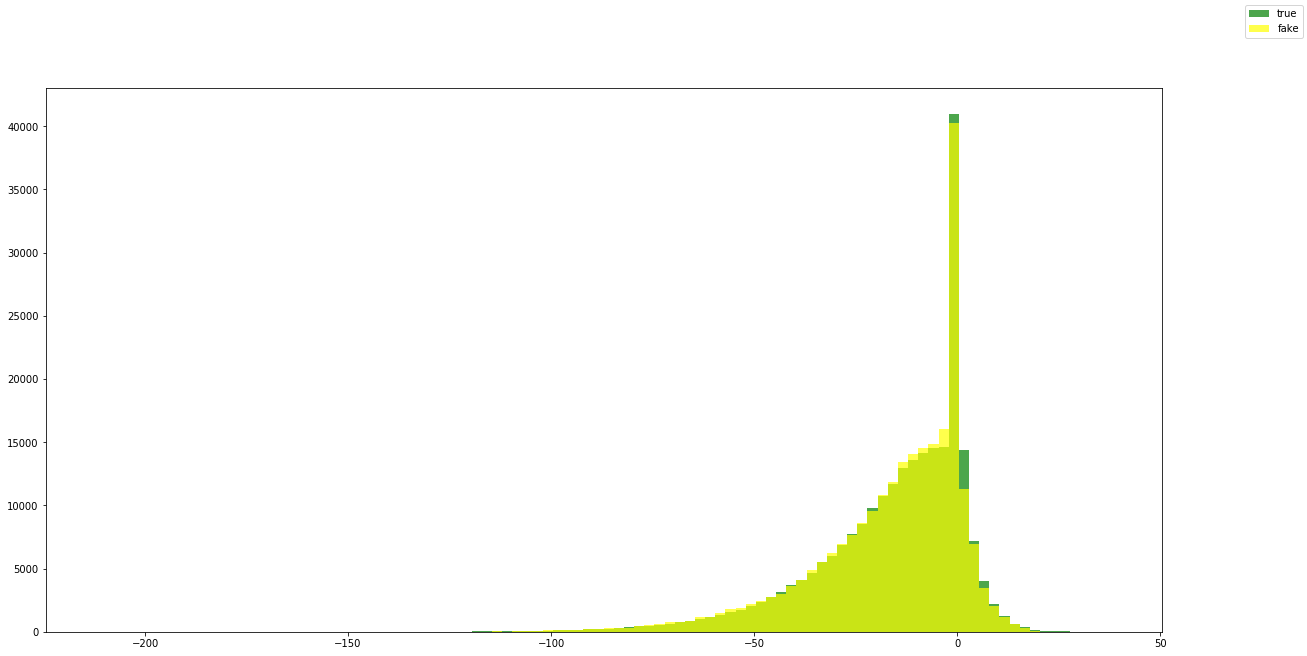

RichDLLe


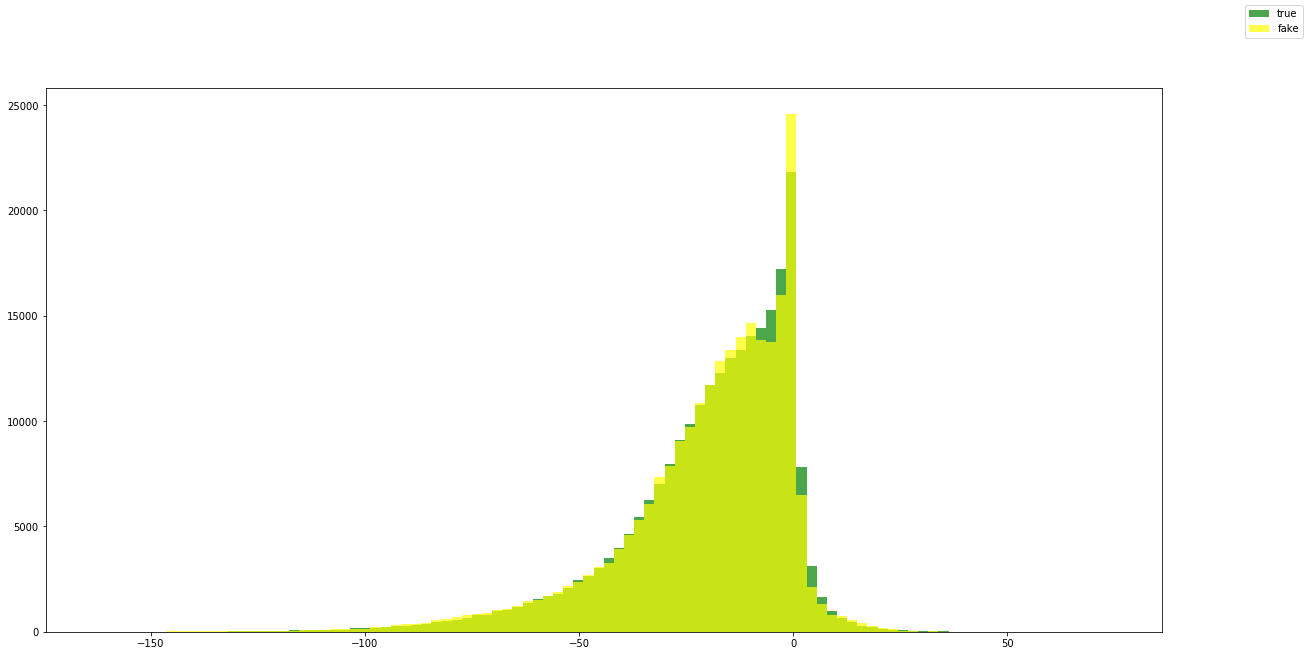

In [15]:
figs_filtered = defaultdict(dict)
scores_filtered = dict()
for particle in tqdm(['proton', 'muon', 'kaon', 'pion']):
    
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    mask1 = (x_test == -999).values.all(axis=1)
    mask2 = (x_test == 0).values.all(axis=1)
    mask = (mask1 | mask2)
    c_test = c_test[~mask]
    x_test = x_test[~mask]
    model = models[particle]
    model.simulate_error_codes = False
    predicted = model.predict(c_test)
    reference = np.c_[x_test.values, c_test.values]
    generated = np.c_[predicted.values, c_test.values]
    score = score_func(generated, reference, n_slices=1000)
    scores_filtered[particle] = score
    print(particle, ': ', score)
    for col in target_cols:
        print(col)
        fig = plot_hist(x_test[col].values, predicted[col].values)
        figs_filtered[particle][col] = fig
        display(fig)
    print('='*100)
        


proton :  0.014208056832227367
RichDLLbt


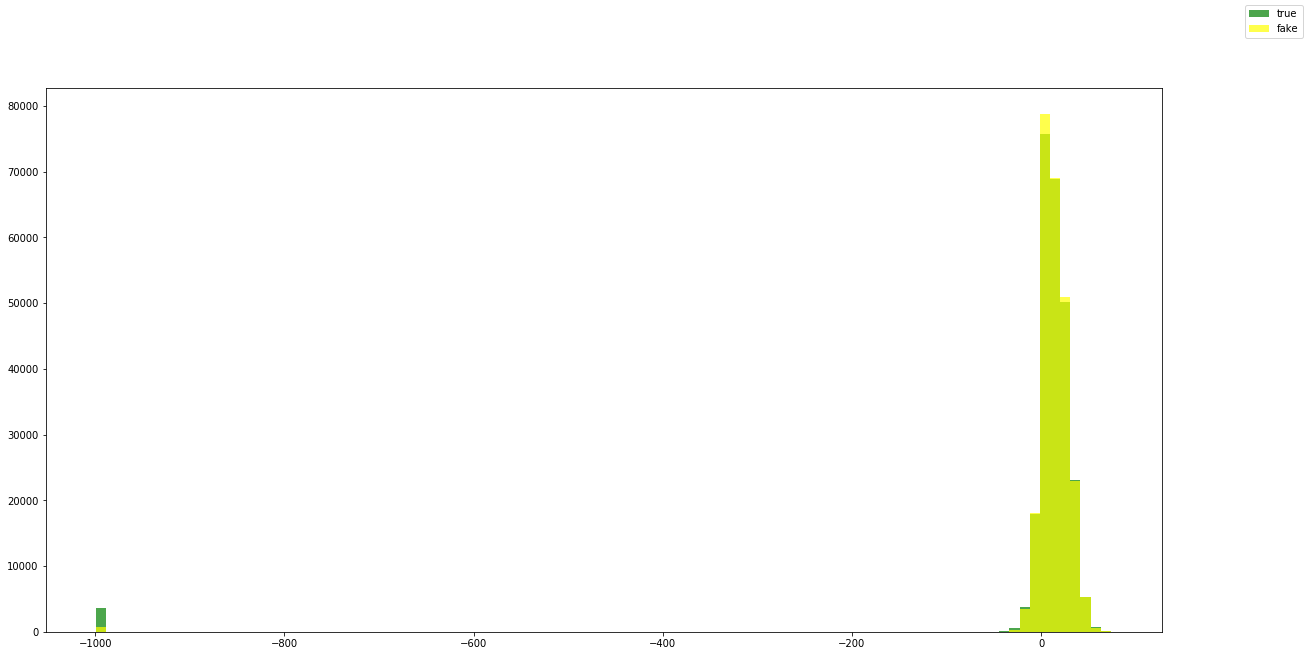

RichDLLk


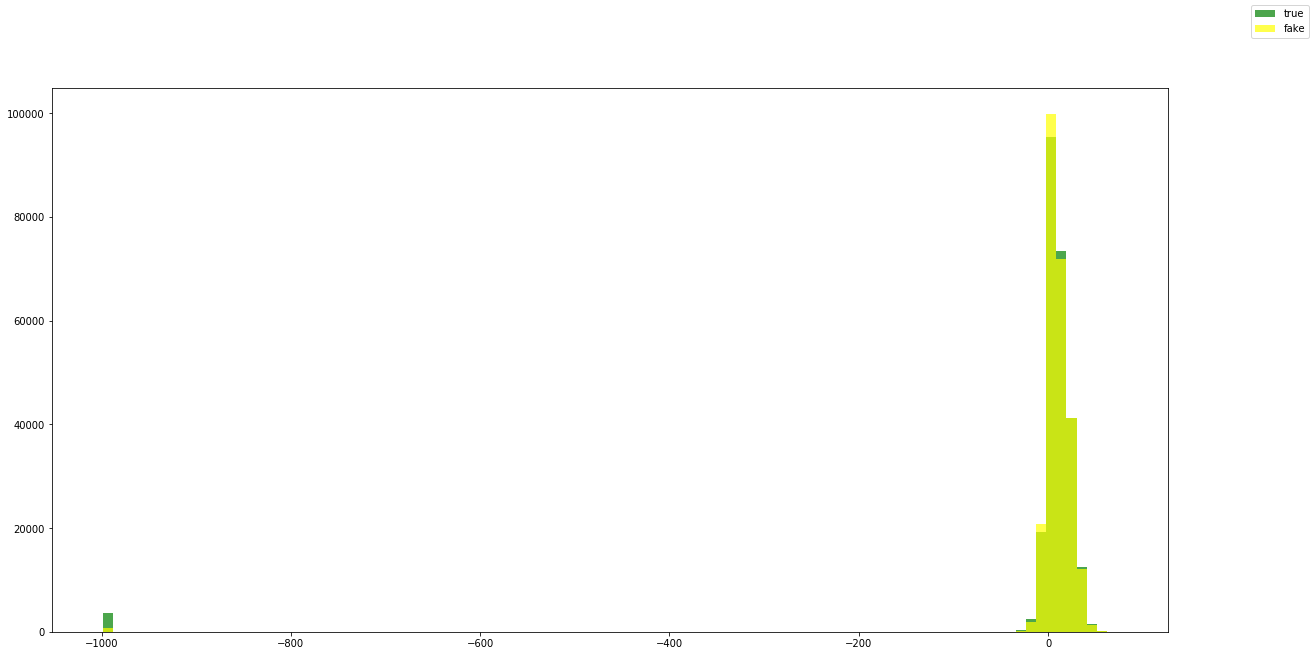

RichDLLmu


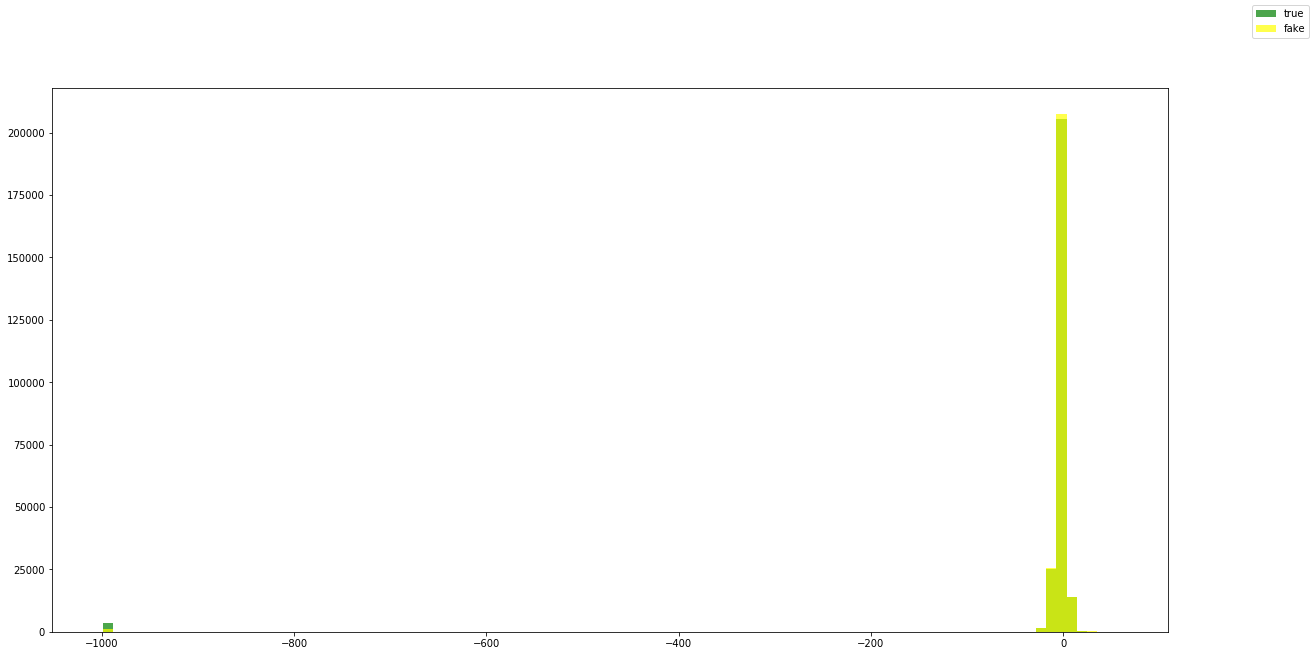

RichDLLp


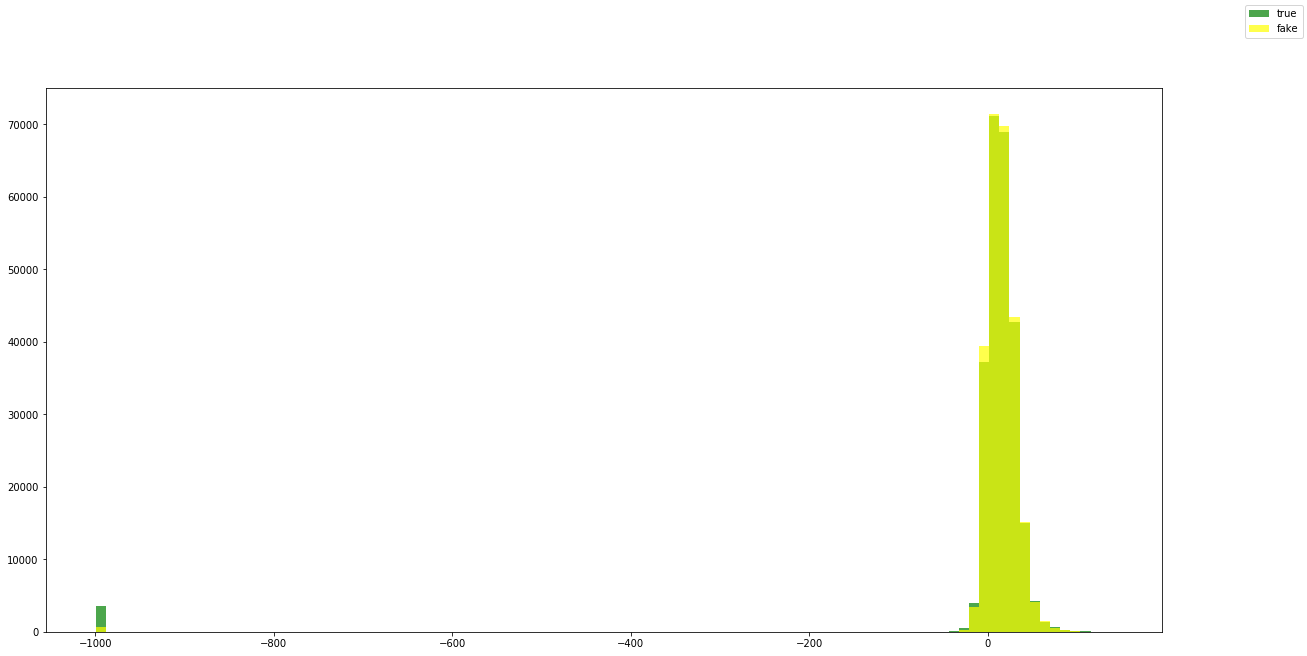

RichDLLe


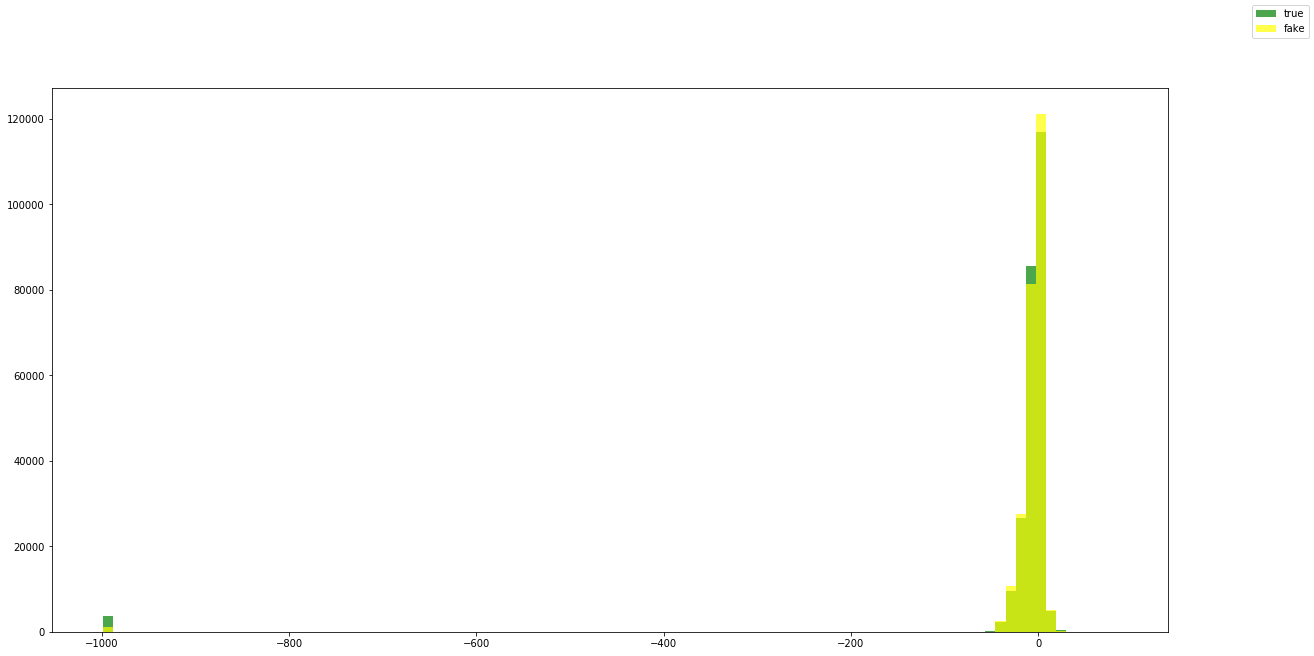


muon :  0.02249191003235984
RichDLLbt


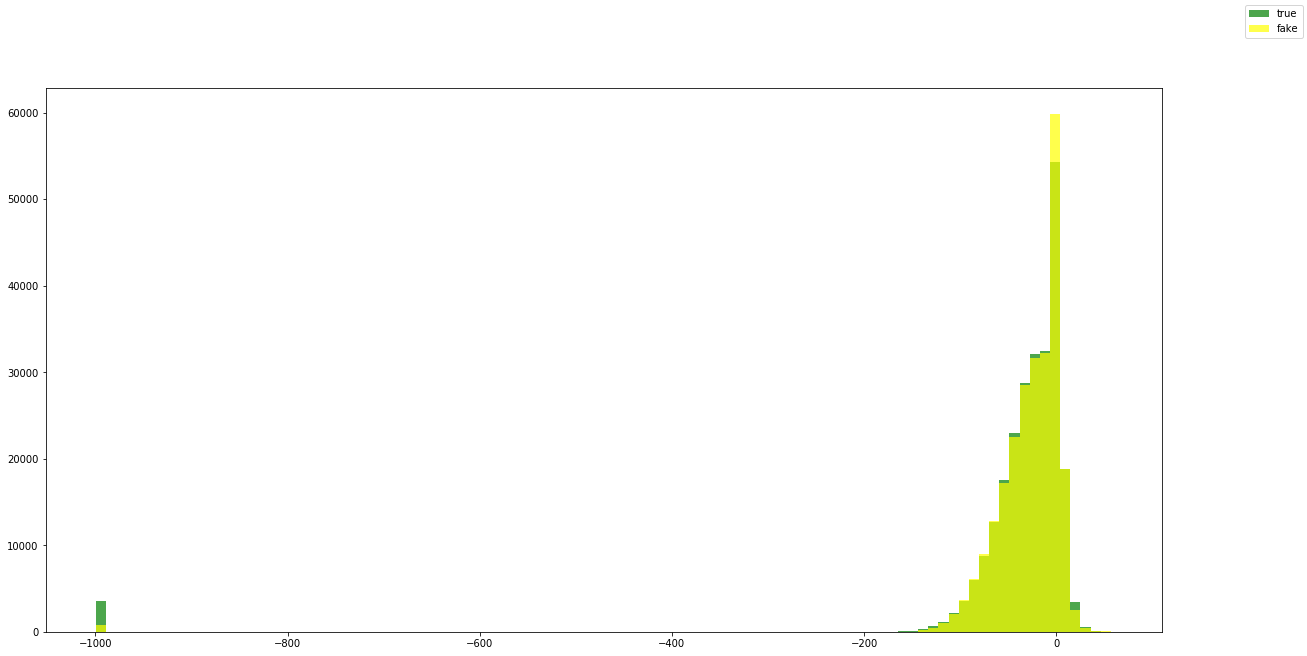

RichDLLk


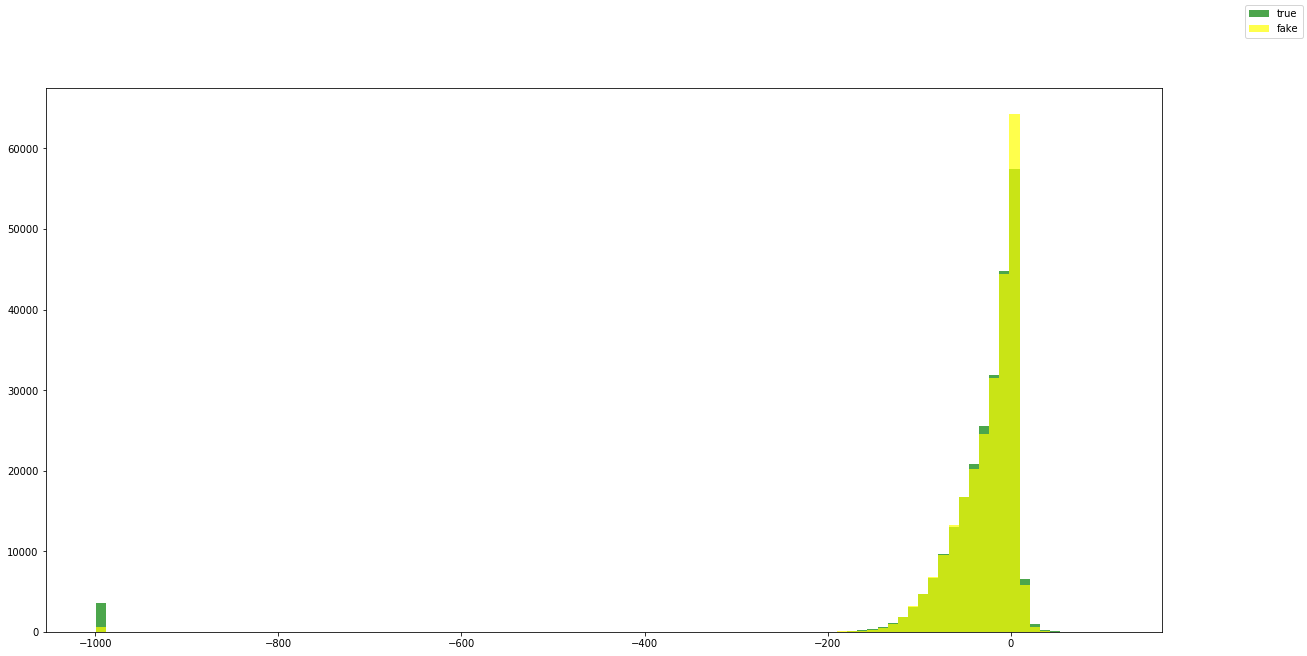

RichDLLmu


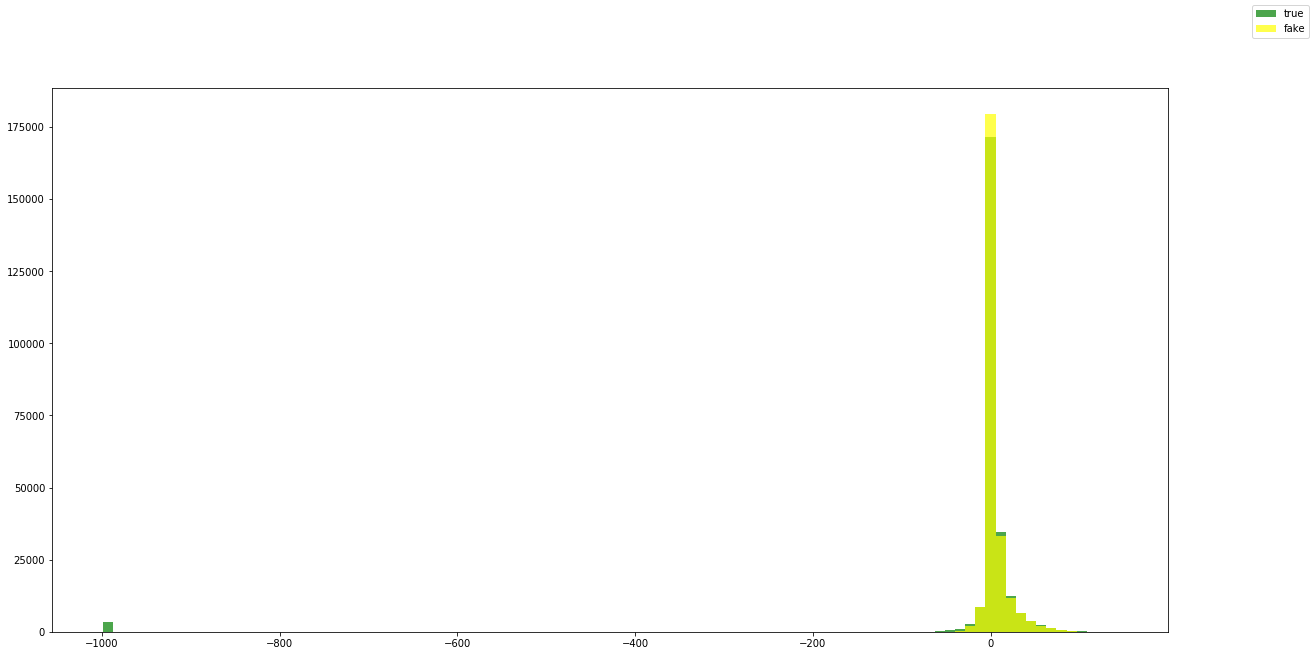

RichDLLp


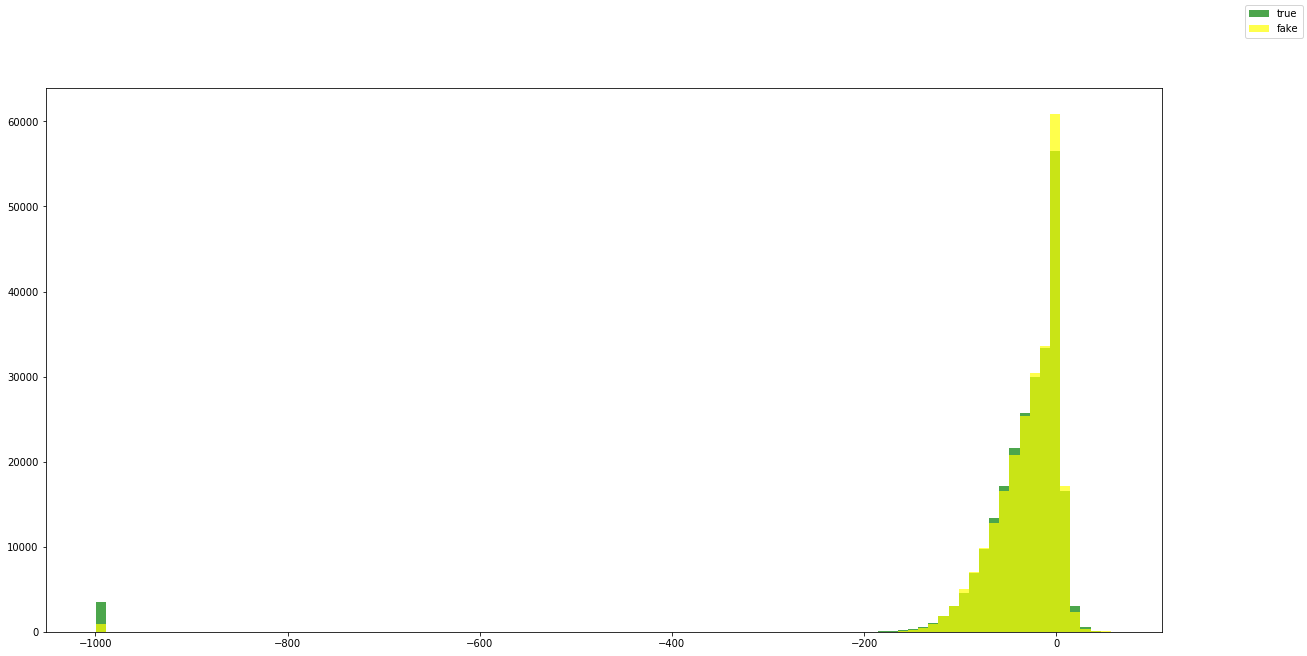

RichDLLe


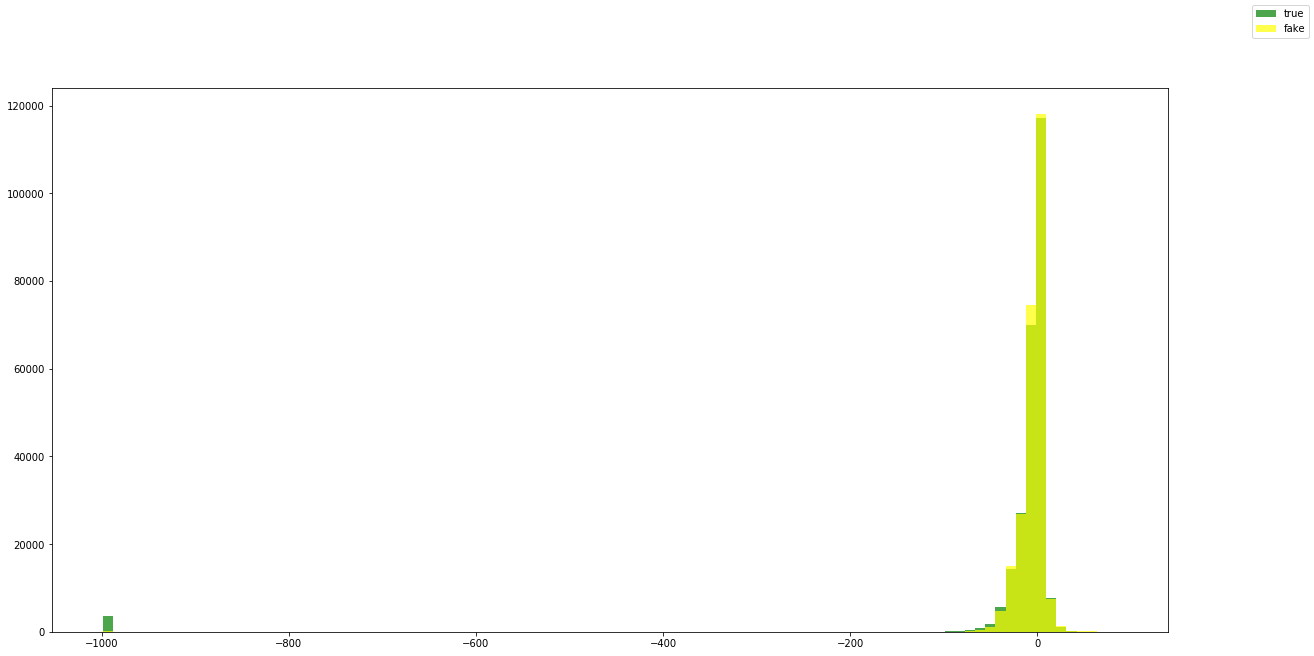


kaon :  0.016408065632262492
RichDLLbt


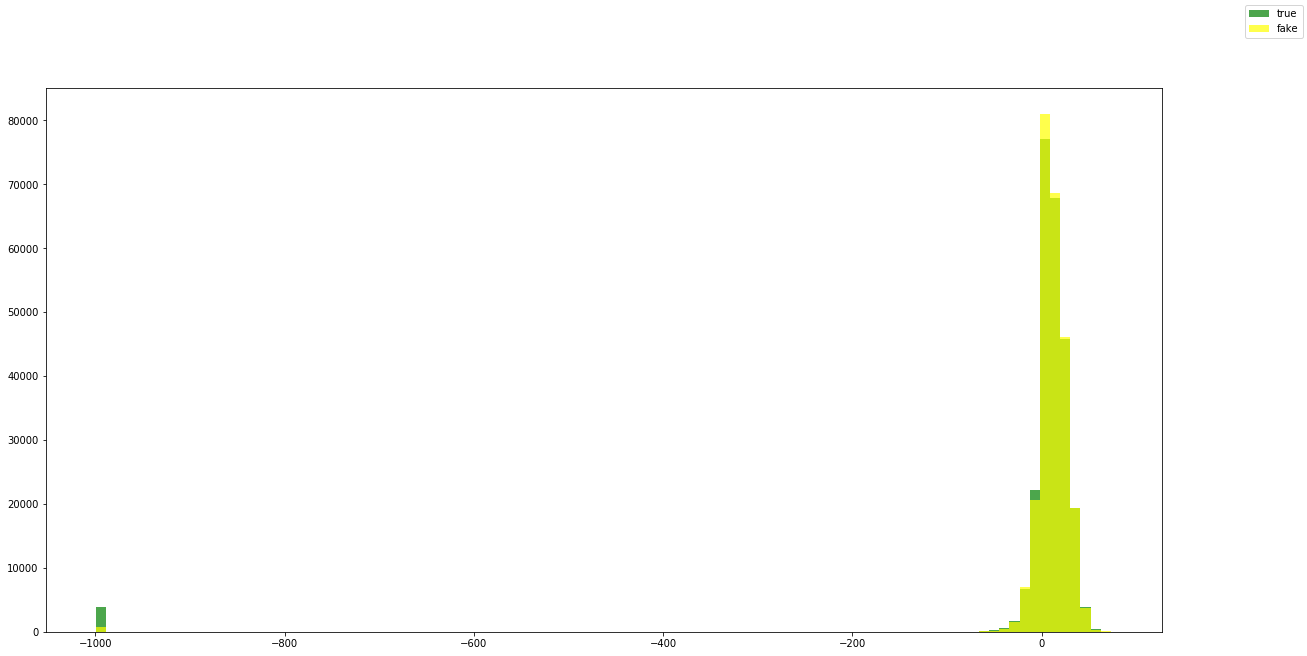

RichDLLk


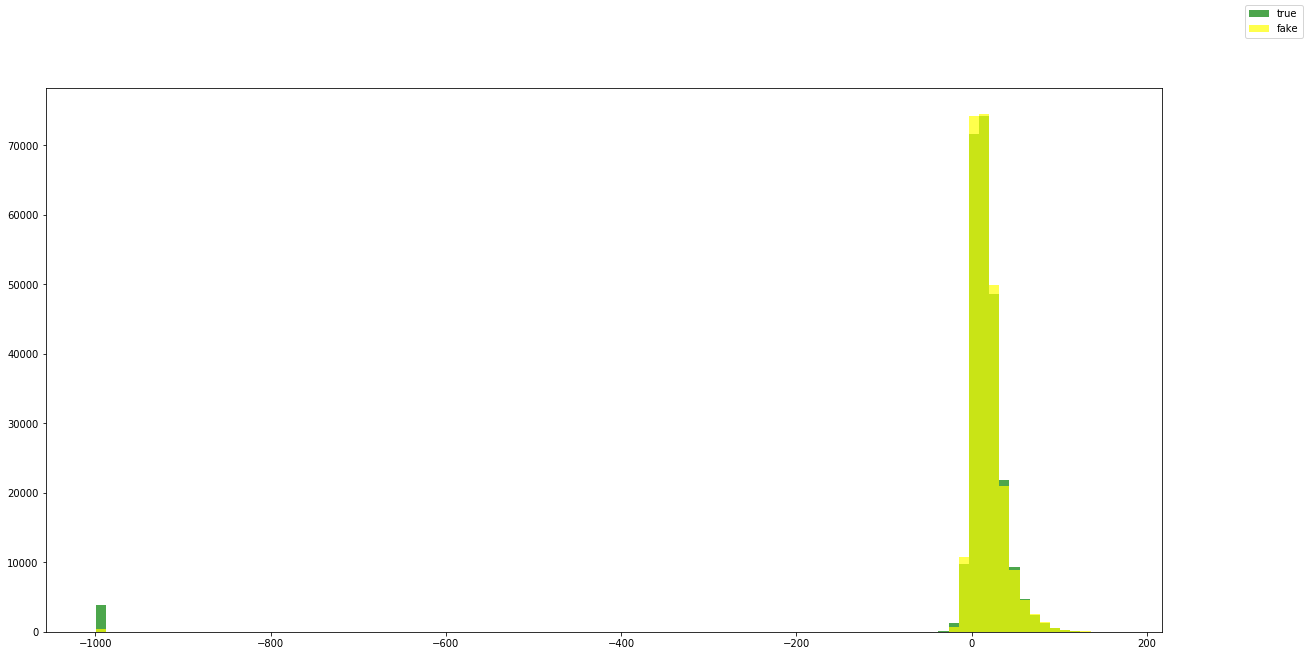

RichDLLmu


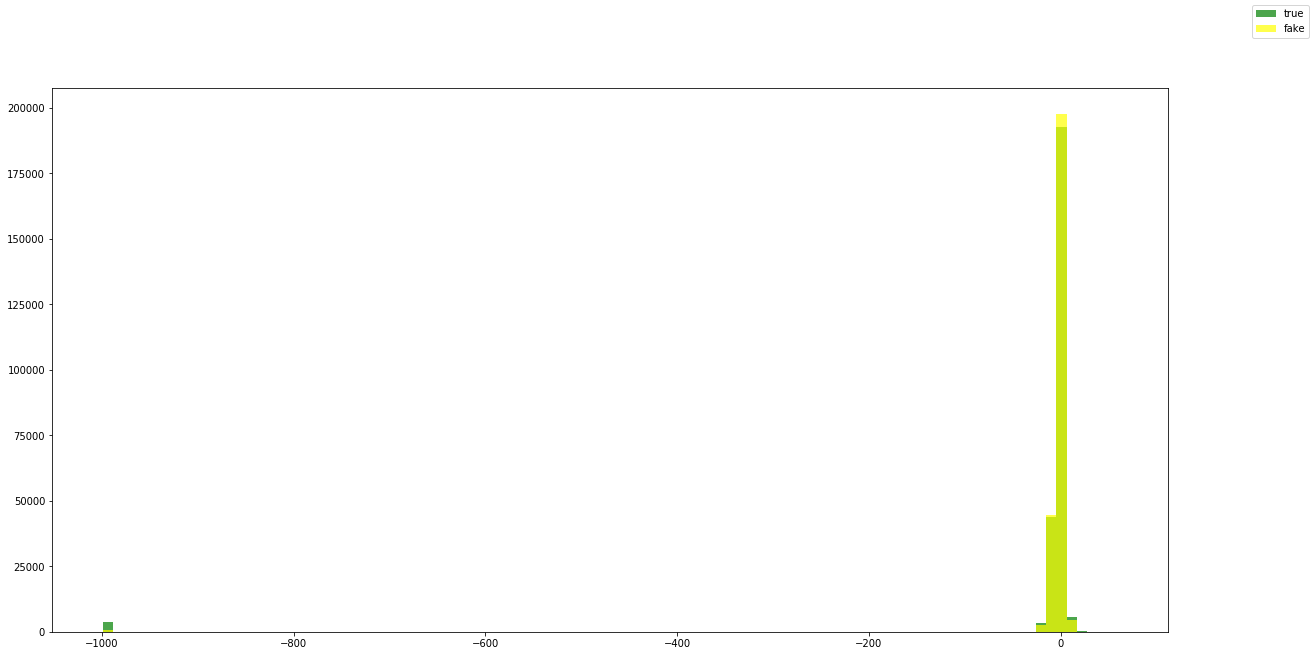

RichDLLp


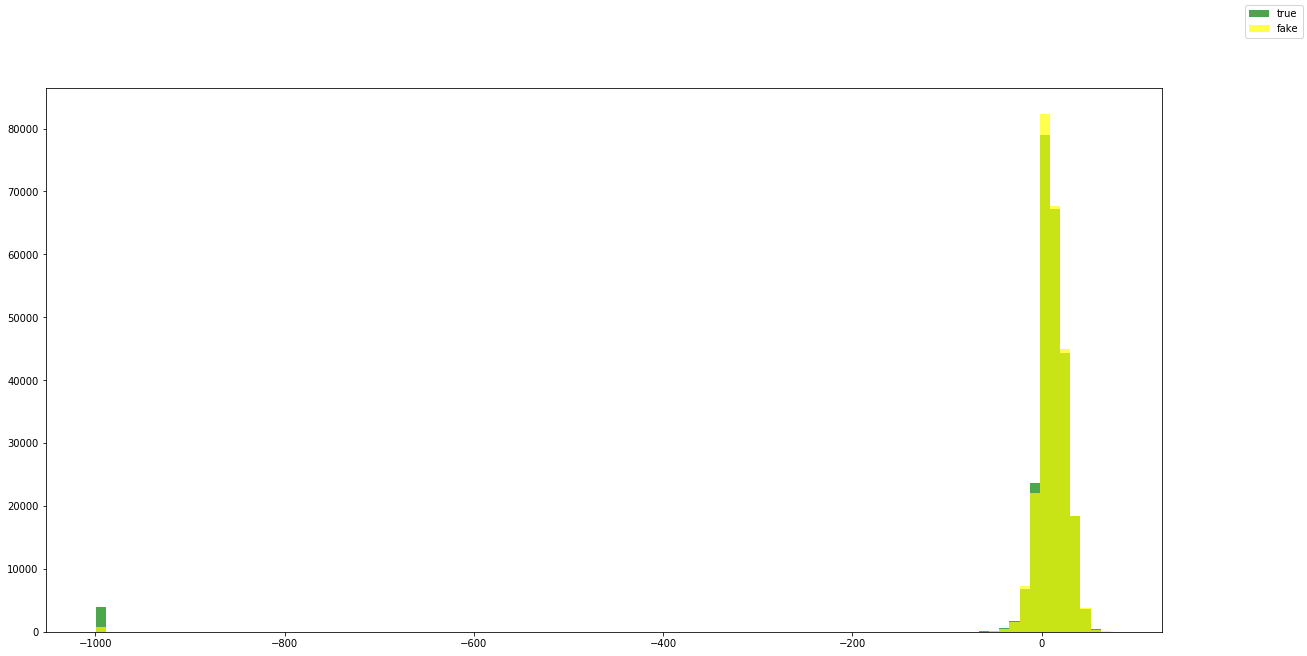

RichDLLe


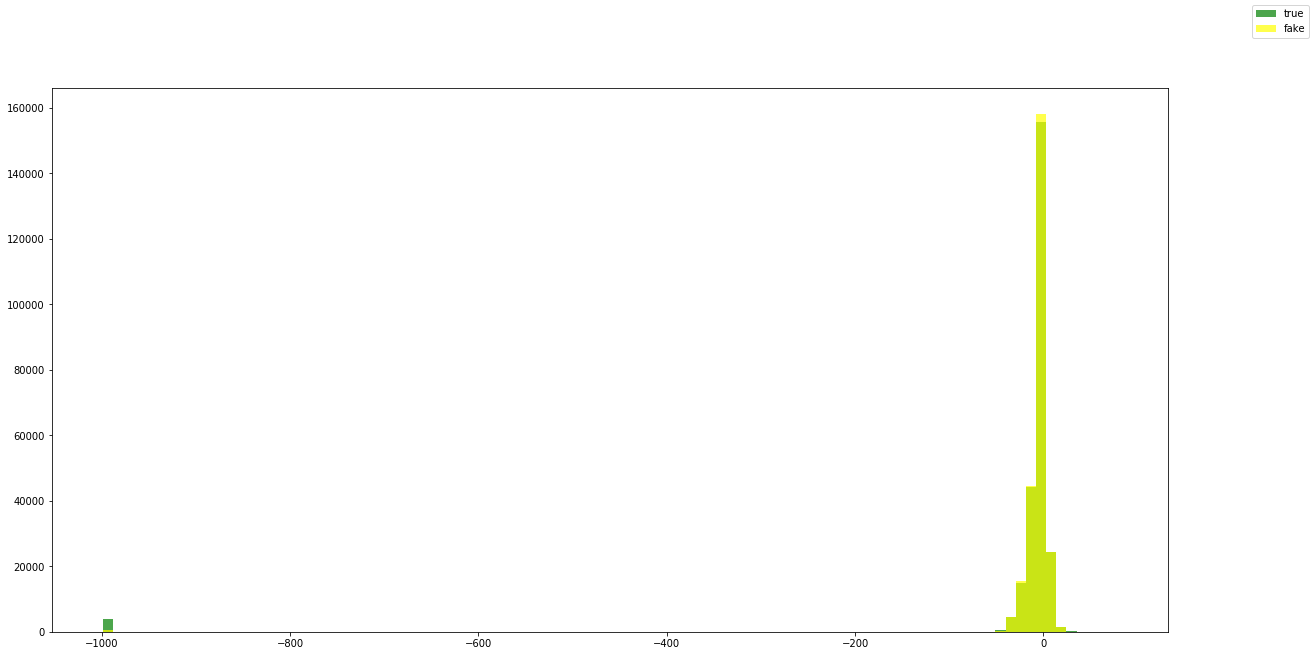


pion :  0.04351965184278528
RichDLLbt


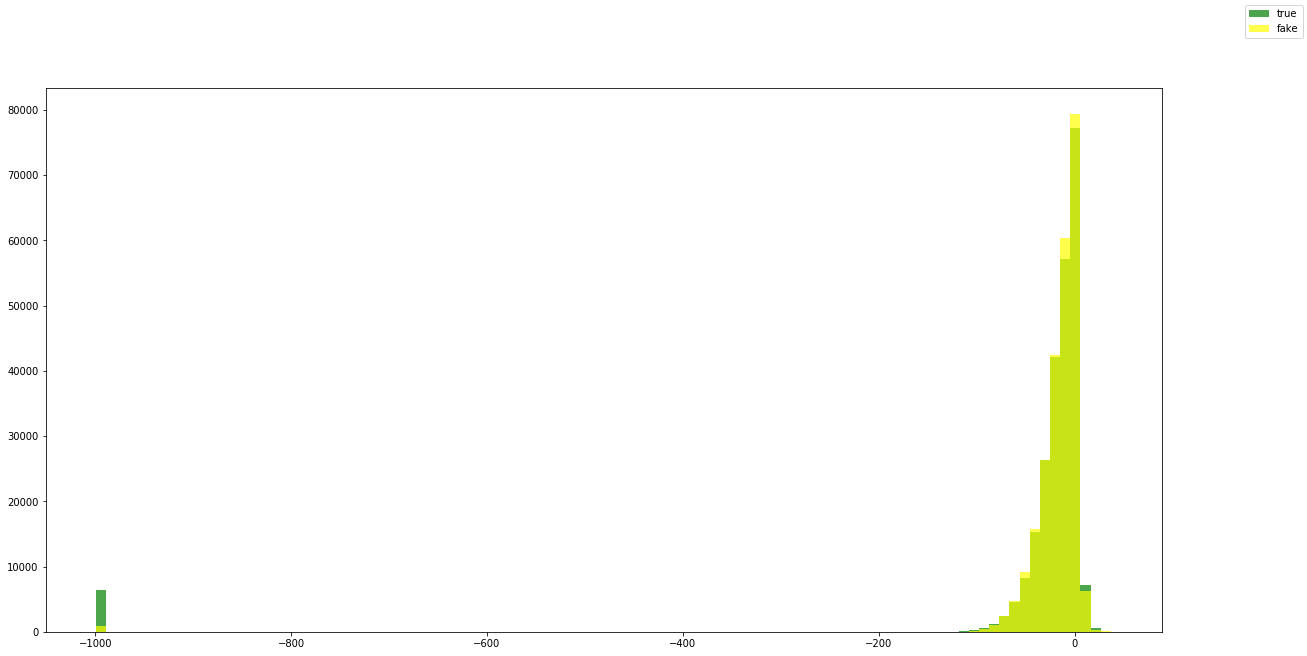

RichDLLk


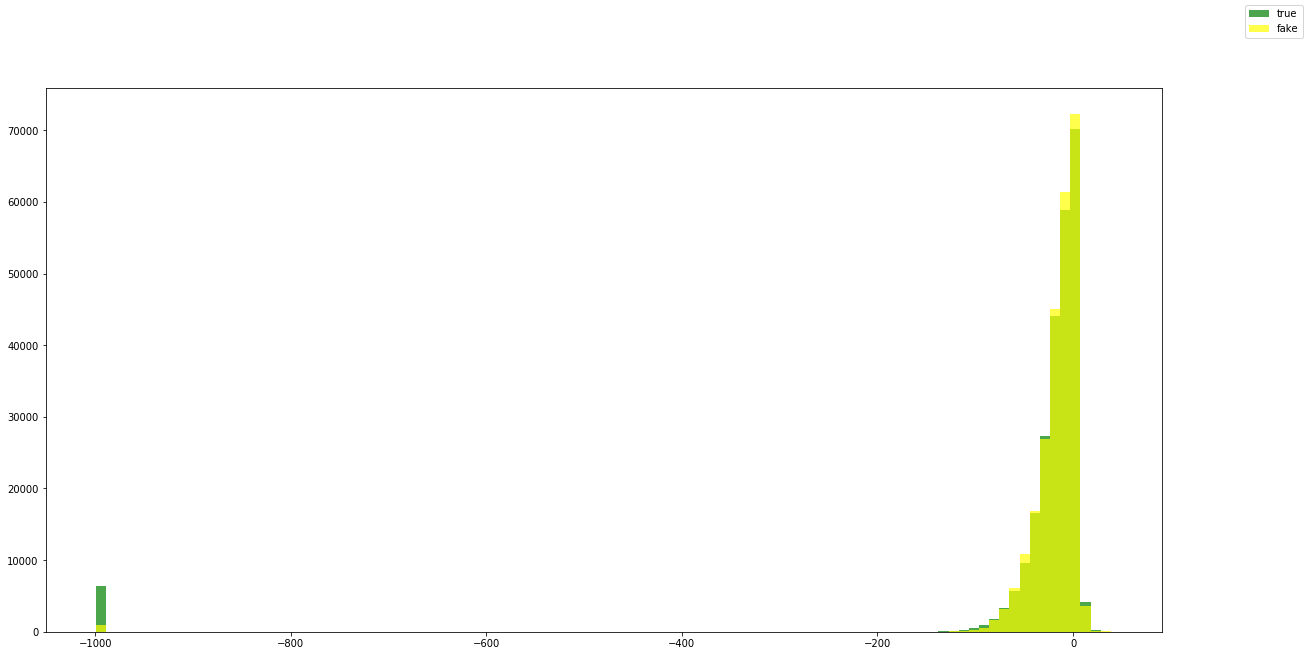

RichDLLmu


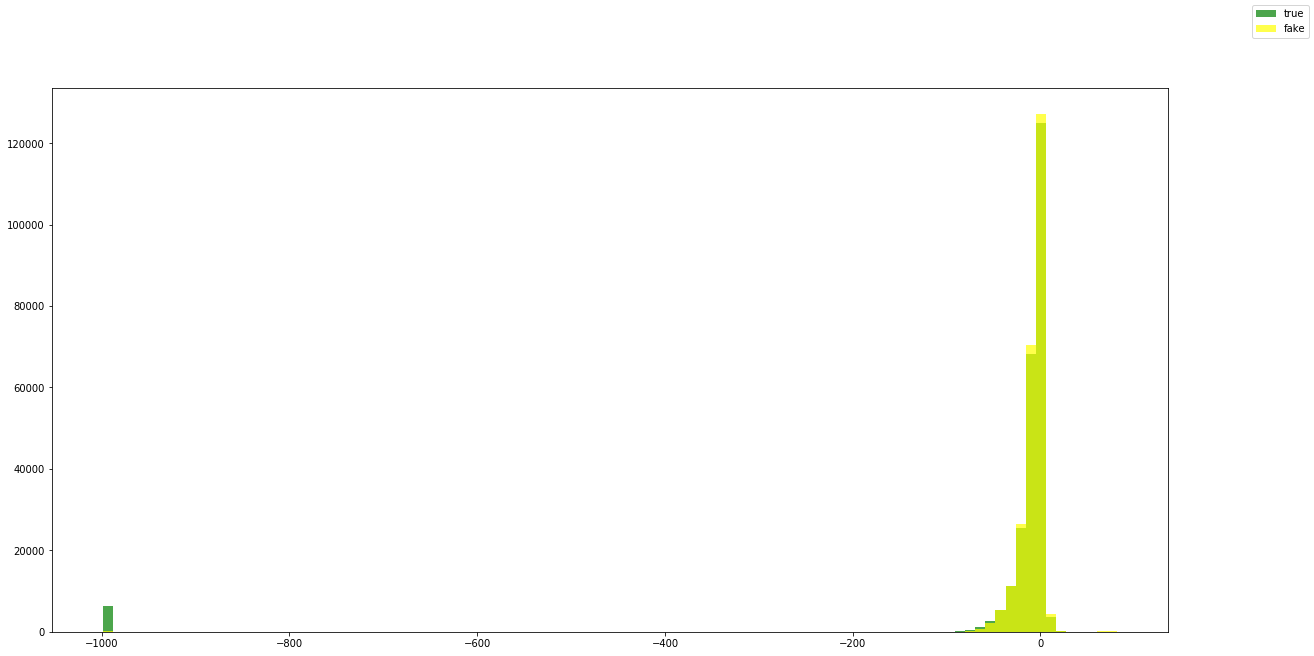

RichDLLp


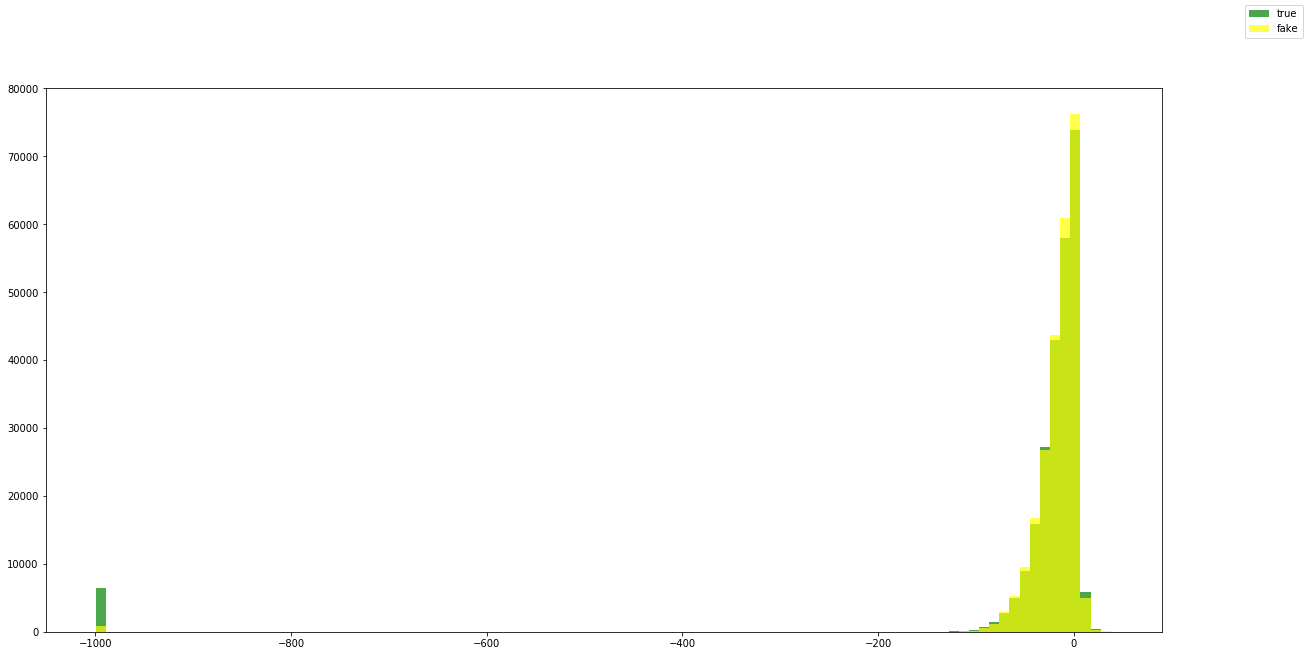

RichDLLe


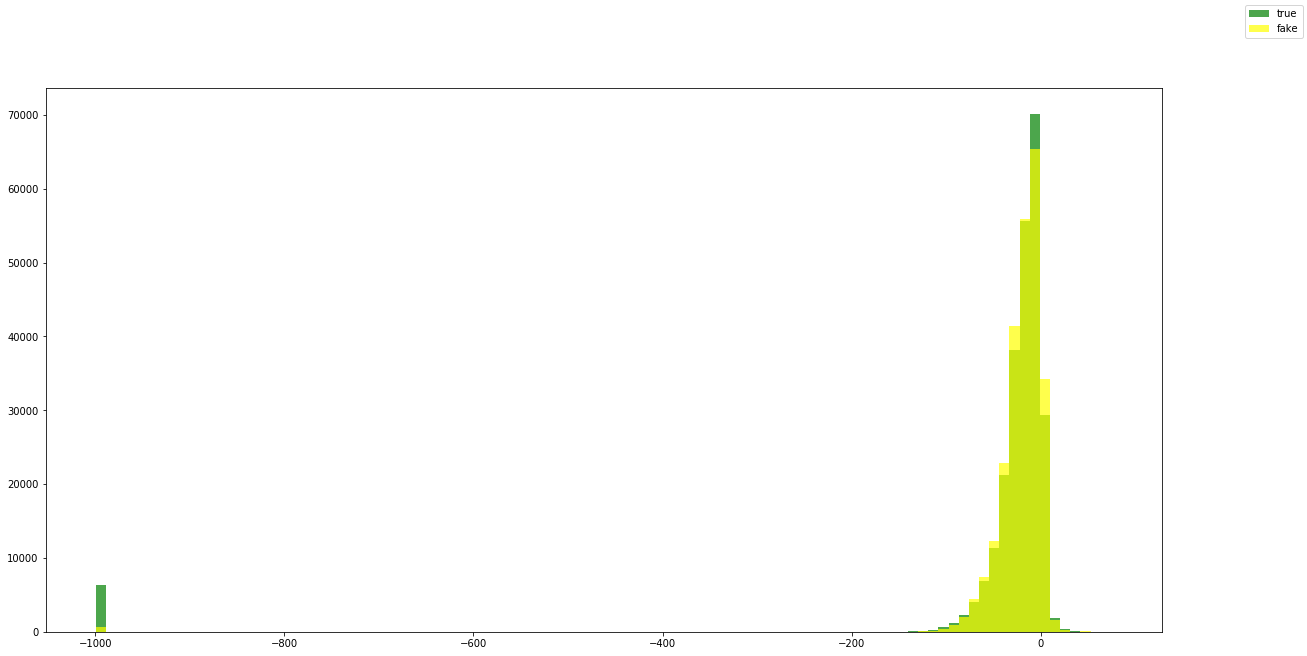

In [7]:
models_polluted = dict()
figs_polluted = defaultdict(dict)
scores_polluted = dict()

for particle in tqdm(['proton', 'muon', 'kaon', 'pion']):
    
    c_train = dataframes[particle]['train'][condition_cols]
    x_train = dataframes[particle]['train'][target_cols]
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    
    model = get_model()
    model.simulate_error_codes = False
    model.fit(
        c_train,
        x_train,
        start_epoch=0,
        num_epochs=50,
        n_critic=1,
        batch_size=512,
        writer=SummaryWriter(log_dir=Path(logdir, tag, particle)),
        num_workers=6,
    )
    models_polluted[particle] = model
    predicted = model.predict(c_test)
    reference = np.c_[x_test.values, c_test.values]
    generated = np.c_[predicted.values, c_test.values]
    score = score_func(generated, reference, n_slices=1000)
    scores_polluted[particle] = score
    print(particle, ': ', score)
    for col in target_cols:
        print(col)
        fig = plot_hist(x_test[col].values, predicted[col].values)
        figs_polluted[particle][col] = fig
        display(fig)
    print('='*100)
        

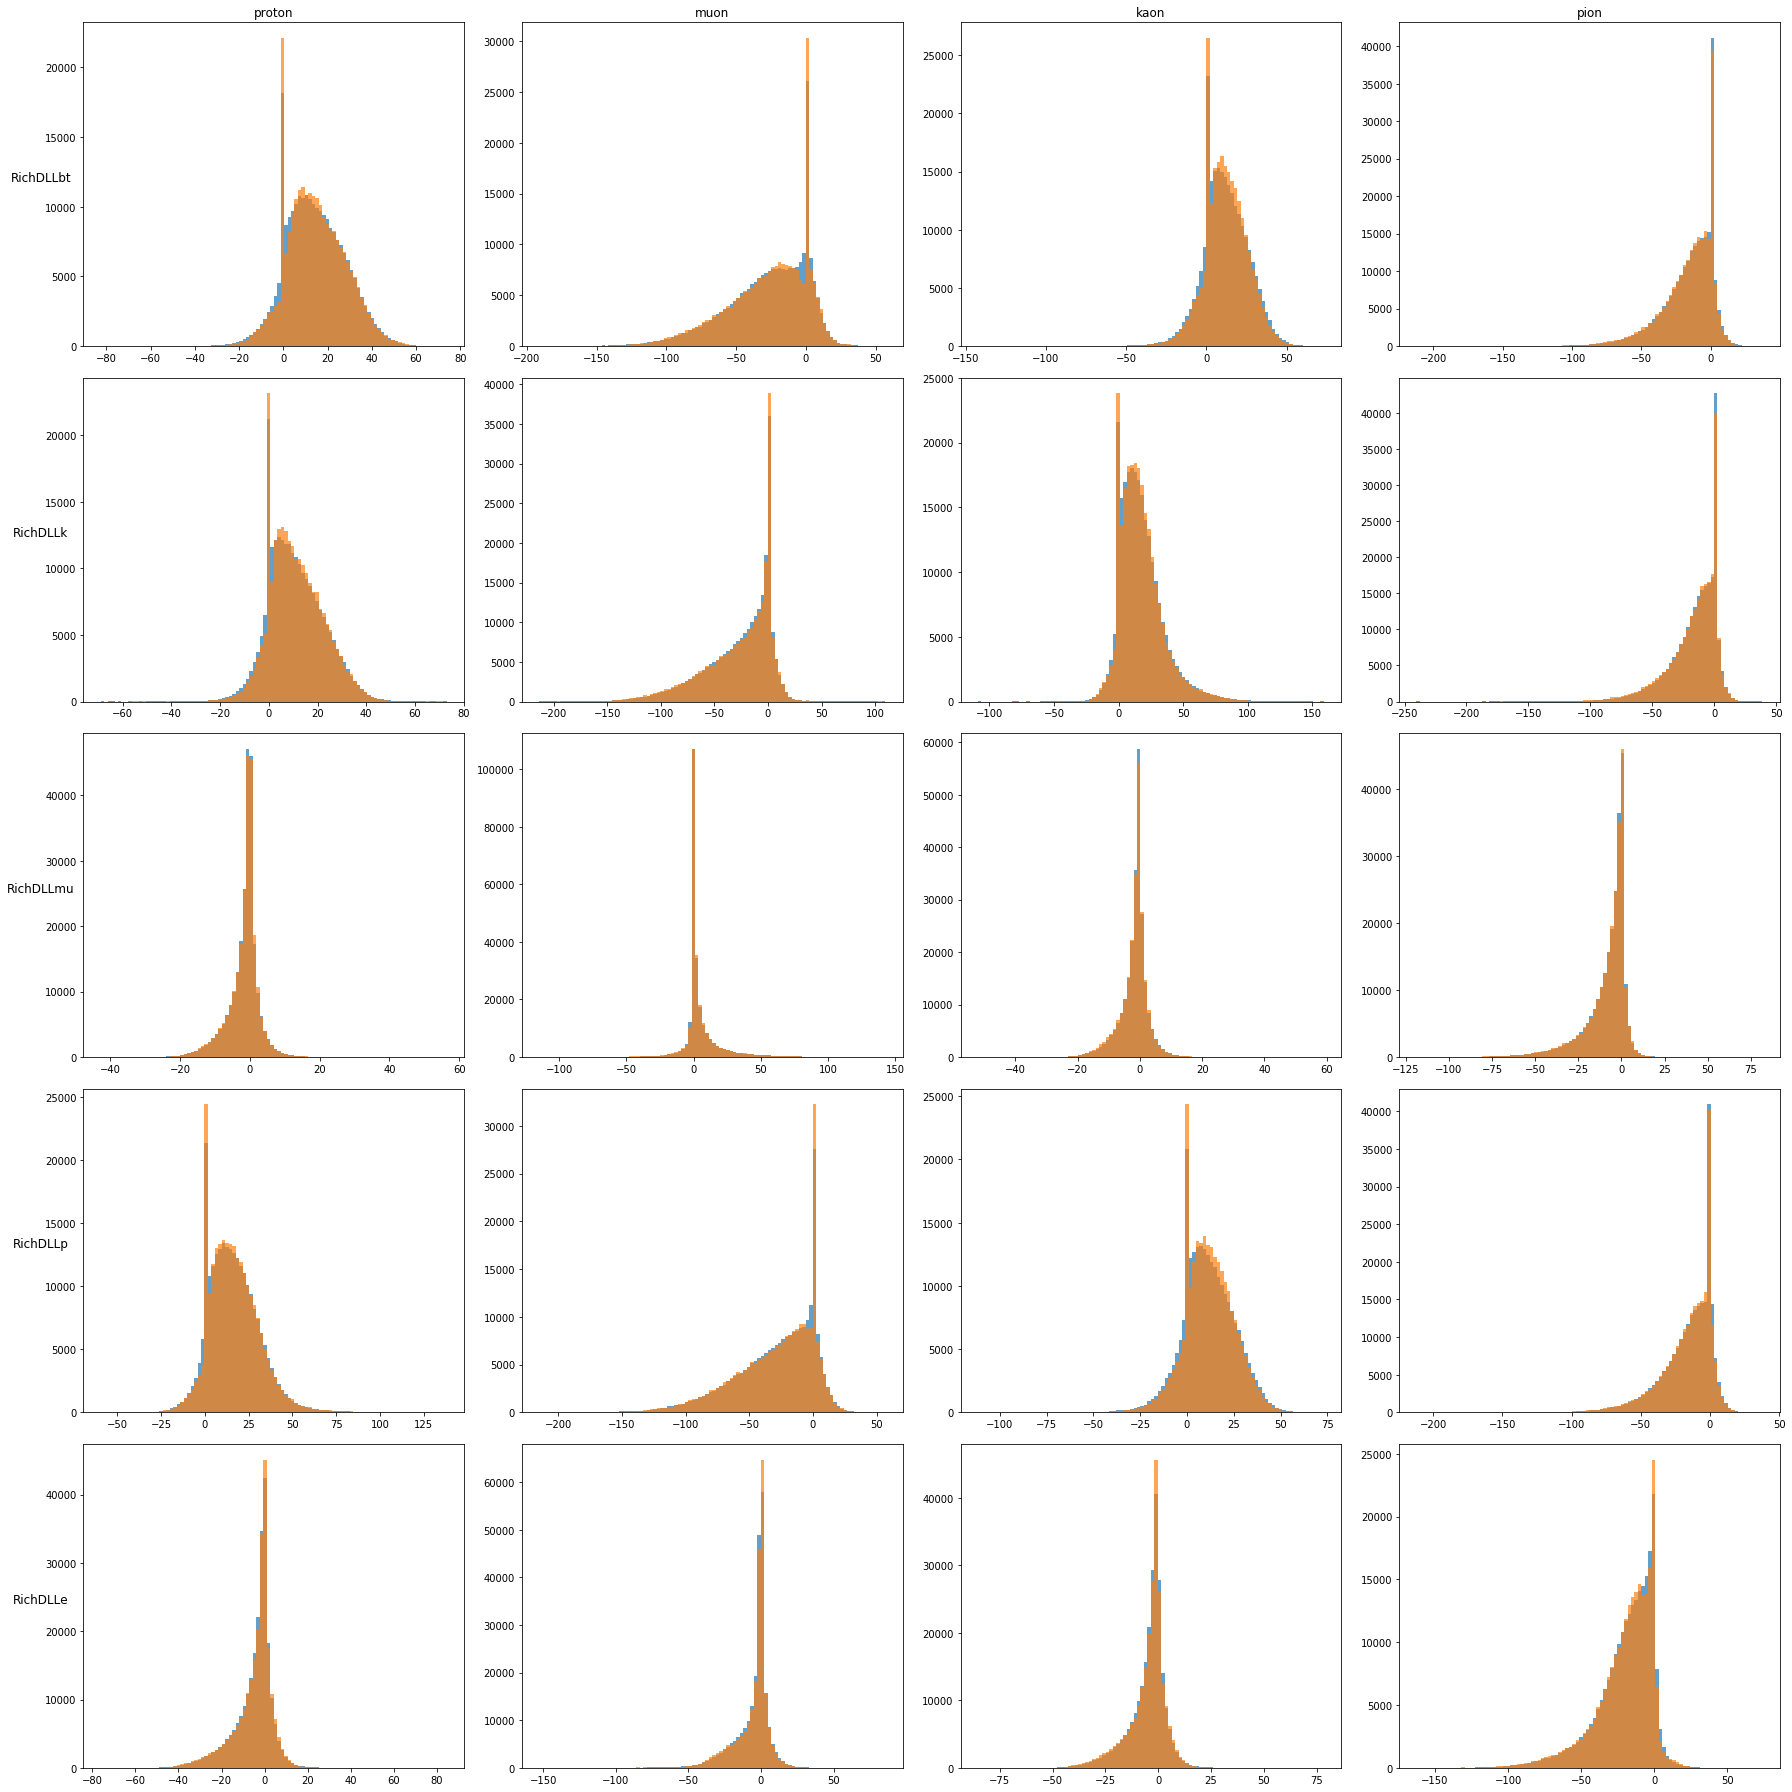

In [20]:
fig, axes = plt.subplots(ncols=4, nrows=len(target_cols), figsize=(25,25))
for j, particle in enumerate(tqdm(['proton', 'muon', 'kaon', 'pion'])):
    
    c_test = dataframes[particle]['test'][condition_cols]
    x_test = dataframes[particle]['test'][target_cols]
    mask1 = (x_test == -999).values.all(axis=1)
    mask2 = (x_test == 0).values.all(axis=1)
    mask = (mask1 | mask2)
    c_test = c_test[~mask]
    x_test = x_test[~mask]
    model = models[particle]
    model.simulate_error_codes = False
    predicted = model.predict(c_test)
    for i, col in enumerate(target_cols):
        _, bins, _ = axes[i][j].hist(x_test[col].values, bins=100, alpha=0.7)
        axes[i][j].hist(predicted[col].values, bins=bins, alpha=0.7)
for ax, col in zip(axes[0], ['proton', 'muon', 'kaon', 'pion']):
    ax.set_title(col)
for ax, row in zip(axes[:,0], target_cols):
    ax.set_ylabel(row,rotation=0, size='large')
fig.tight_layout()
fig.savefig(f'/_data/pics/vanila_preds.png', format='png')

In [19]:
[round(x, 3) for x in scores_filtered.values()]

[0.011, 0.017, 0.012, 0.015]

In [14]:
[round(xscores_polluted

{'proton': 0.014208056832227367,
 'muon': 0.02249191003235984,
 'kaon': 0.016408065632262492,
 'pion': 0.04351965184278528}

In [10]:
figs['kaon']['RichDLLbt'].savefig

<bound method Figure.savefig of <Figure size 1440x720 with 1 Axes>>

In [11]:
for particle in figs:
    for col in figs[particle]:
        p = Path(f'/_data/richgan/pics/{tag}', particle)
        p.mkdir(parents=True, exist_ok=True)
        figs[particle][col].savefig(Path(p, col).with_suffix('.png').as_posix(), format='png')

In [12]:
for particle in figs_filtered:
    for col in figs_filtered[particle]:
        p = Path(f'/_data/richgan/pics/{tag}/', particle)
        p.mkdir(parents=True, exist_ok=True)
        figs_filtered[particle][col].savefig(Path(p, f'{col}-filtered').with_suffix('.png').as_posix(), format='png')

In [13]:
for particle in figs_polluted:
    for col in figs_polluted[particle]:
        p = Path(f'/_data/richgan/pics/{tag}/', particle)
        p.mkdir(parents=True, exist_ok=True)
        figs_polluted[particle][col].savefig(Path(p, f'{col}-polluted').with_suffix('.png').as_posix(), format='png')